## **1. EXPLORATORY DATA ANALYSIS**

Analysis of variables with their corresponding business interpretation


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [79]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data with proper handling of missing values
print("Loading data...")
#---------------------------------------
df = pd.read_csv("C:\\Users\\evzqn\\OneDrive\\Documents\\MiF 2025-2026\\Assignments\\Machine Learning\\UCI_Credit_Card.csv")

# CRITICAL FIX: Handle missing values before any operations
# Replace any infinite values with NaN first
df = df.replace([np.inf, -np.inf], np.nan)

# Print missing value summary
print(f"\nDataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nMissing values per column:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values detected")

# Define variable types
numerical_vars = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

categorical_vars = ['home_ownership', 'verification_status', 'purpose', 'grade', 'sub_grade']

# Remove any numerical variables that are all NaN
numerical_vars = [var for var in numerical_vars if var in df.columns and not df[var].isnull().all()]

print(f"\nAnalyzing {len(numerical_vars)} numerical variables and {len(categorical_vars)} categorical variables")

Loading data...

Dataset loaded: 30000 rows, 25 columns

Missing values per column:
No missing values detected

Analyzing 25 numerical variables and 5 categorical variables



PART 1: UNIVARIATE ANALYSIS - NUMERICAL VARIABLES


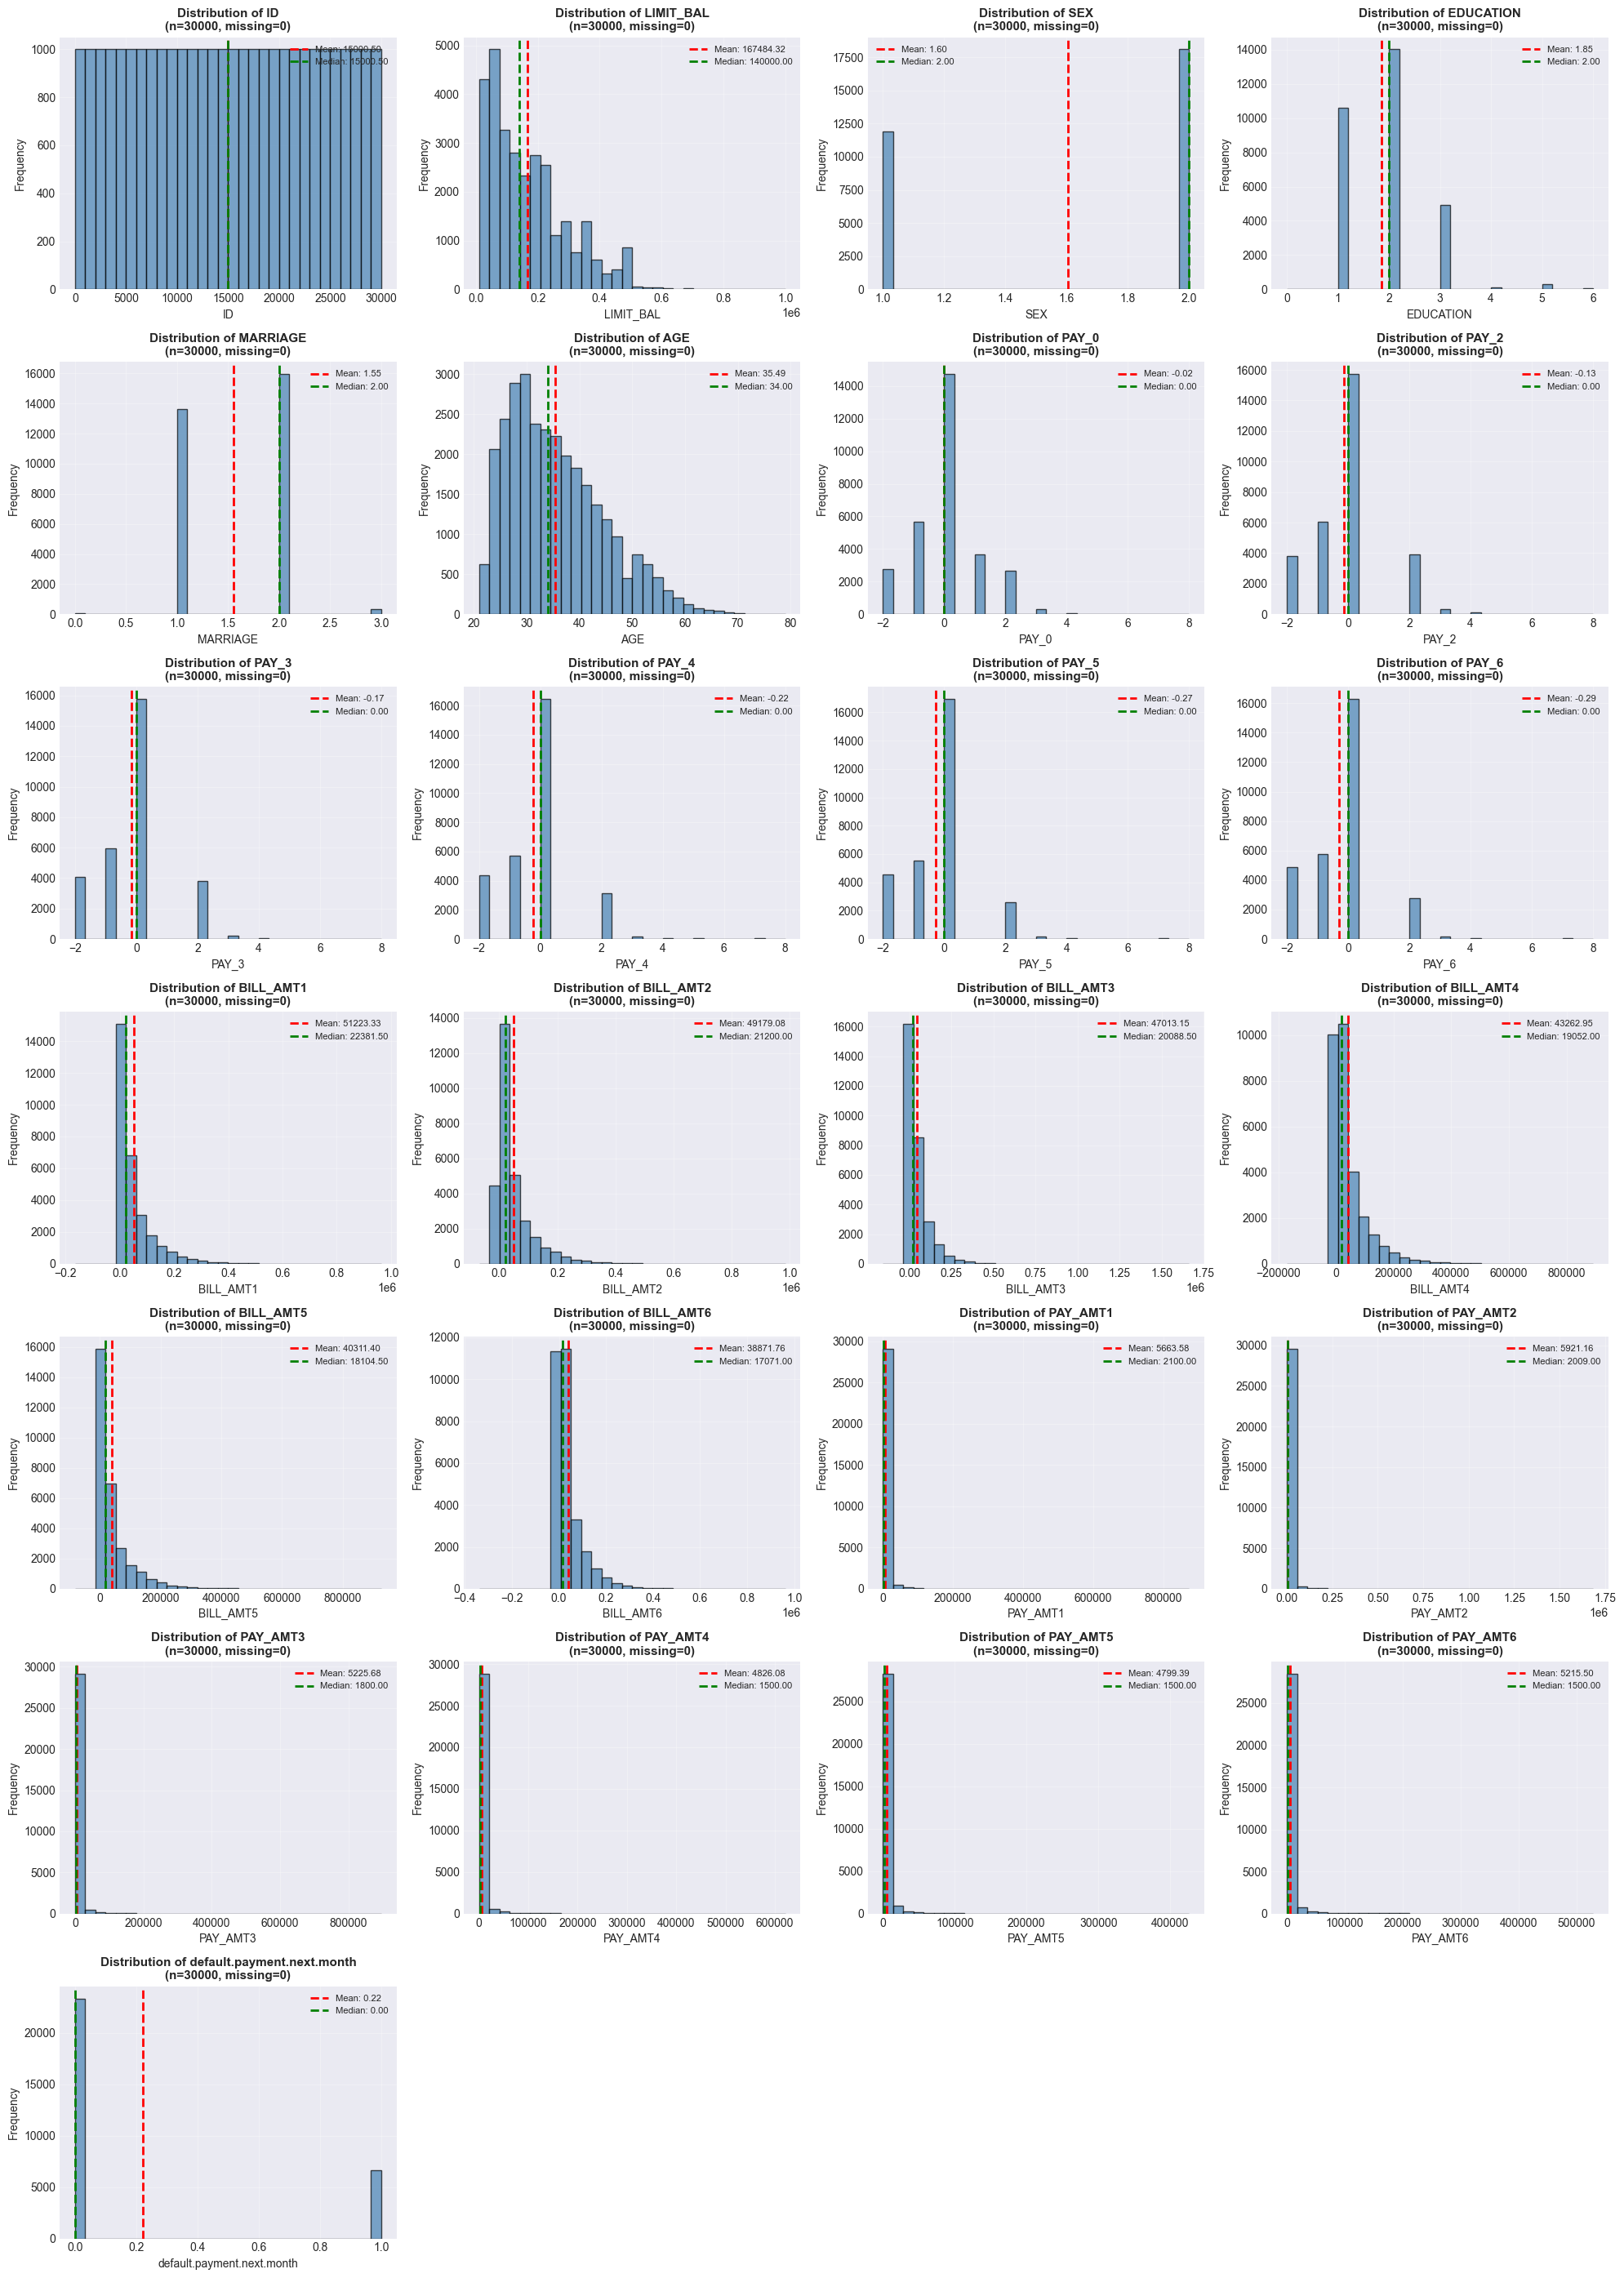

In [80]:
# ============================================================================
# PART 1: UNIVARIATE ANALYSIS - NUMERICAL VARIABLES
# ============================================================================
print("\n" + "="*80)
print("PART 1: UNIVARIATE ANALYSIS - NUMERICAL VARIABLES")
print("="*80)

# Calculate grid size for numerical variables
n_num = len(numerical_vars)
n_cols = 4
n_rows = int(np.ceil(n_num / n_cols))

fig1, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()

for idx, var in enumerate(numerical_vars):
    ax = axes[idx]
    # Drop NaN values for plotting
    data = df[var].dropna()

    if len(data) > 0:
        ax.hist(data, bins=min(30, len(data)), edgecolor='black', alpha=0.7, color='steelblue')
        ax.set_xlabel(var, fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_title(f'Distribution of {var}\n(n={len(data)}, missing={df[var].isna().sum()})',
                     fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Add statistics
        mean_val = data.mean()
        median_val = data.median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        ax.legend(fontsize=8)
    else:
        ax.text(0.5, 0.5, f'{var}\n(All NaN)', ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])

# Hide unused subplots
for idx in range(n_num, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## **Business Interpretation of the numerical variable distributions:**

*The histograms reveal the underlying distribution of our loan portfolio. The most business-relevant variables are:*

1. **Interest Rate:** The distribution shows a skewed pattern with most loans concentrated between 10-15%, and a tail extending to 25%+. The shape suggests a balanced portfolio that doesn't over-concentrate in either very safe or very risky loans.

2. **Debt-to-Income Ratio:** The DTI distribution is right-skewed, resembling a log-normal pattern rather than a perfectly normal distribution. This skew is expected as DTI is a ratio bounded at zero and naturally produces a longer right tail. However, the sharp decline in observations beyond approximately 35-40% indicates that borrowers with high debt are rarely present in the approved loan portfolio. This can suggest that Lending Club applies rules during underwriting with either fixed thresholds or stricter approval criteria that limit loan approvals for applicants with high DTI.

3. **Revolving Utilization:** Revolving utilization measures the share of available revolving credit currently in use. The distribution is roughly symmetric and centered around 50%, indicating that most approved borrowers use a moderate portion of their revolving credit. Unlike DTI, high utilization values are still present, suggesting that revol_util is treated as a continuous risk signal rather than a strict screening variable.

4. **Annual Income:** The right-skewed distribution shows most borrowers earning between $40,000 and $80,000 (with a long tail of high earners). This shows that Lending Club's core market is around middle-class Americans seeking personal loans. The median is more representative than the mean due to high-income outliers.

5. **Term:** The term distribution is bimodal, reflecting Lending Club’s two standard loan maturities of 36 and 60 months. The higher frequency of 36-month loans indicates that short-term loans are issued more often than long-term loans, suggesting a portfolio tilt toward shorter maturities.

In [81]:
# ============================================================================
# PART 1A: BOX PLOTS - NUMERICAL VARIABLES BY DEFAULT STATUS
# ============================================================================
print("\n" + "="*80)
print("PART 1A: BOX PLOTS - COMPARING DEFAULT VS NON-DEFAULT")
print("="*80)

if 'default' in df.columns and df['default'].notna().any():
    # Calculate grid size for box plots
    n_cols_box = 4
    n_rows_box = int(np.ceil(n_num / n_cols_box))

    fig_box, axes_box = plt.subplots(n_rows_box, n_cols_box, figsize=(20, n_rows_box*4))
    axes_box = axes_box.flatten()

    for idx, var in enumerate(numerical_vars):
        ax = axes_box[idx]

        # Create clean data without NaN
        valid_mask = df[var].notna() & df['default'].notna()
        plot_data = df[valid_mask]

        if len(plot_data) > 0 and plot_data['default'].nunique() > 1:
            # Separate data by default status
            data_no_default = plot_data[plot_data['default'] == 0][var]
            data_default = plot_data[plot_data['default'] == 1][var]

            # Create box plot
            bp = ax.boxplot([data_no_default, data_default],
                           labels=['No Default', 'Default'],
                           patch_artist=True,
                           showmeans=True,
                           meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

            # Color the boxes
            bp['boxes'][0].set_facecolor('lightgreen')
            bp['boxes'][1].set_facecolor('lightcoral')

            # Styling
            ax.set_ylabel(var, fontsize=10)
            ax.set_title(f'Box Plot: {var} by Default Status\n(n={len(plot_data)})',
                        fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y')

            # Add statistics text box
            stats_text = f'No Default:\n  Mean: {data_no_default.mean():.2f}\n  Median: {data_no_default.median():.2f}\n'
            stats_text += f'Default:\n  Mean: {data_default.mean():.2f}\n  Median: {data_default.median():.2f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                   verticalalignment='top', fontsize=7,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        else:
            ax.text(0.5, 0.5, f'{var}\n(Insufficient data)',
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])

    # Hide unused subplots
    for idx in range(n_num, len(axes_box)):
        axes_box[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate and print statistical comparison
    print("\nStatistical Comparison (Mean values):")
    print("-" * 80)
    comparison_stats = []
    for var in numerical_vars:
        valid_mask = df[var].notna() & df['default'].notna()
        if valid_mask.sum() > 0 and df[valid_mask]['default'].nunique() > 1:
            no_default_mean = df[valid_mask & (df['default'] == 0)][var].mean()
            default_mean = df[valid_mask & (df['default'] == 1)][var].mean()
            difference = default_mean - no_default_mean
            pct_diff = (difference / no_default_mean * 100) if no_default_mean != 0 else np.nan

            comparison_stats.append({
                'Variable': var,
                'No Default (Mean)': no_default_mean,
                'Default (Mean)': default_mean,
                'Difference': difference,
                '% Difference': pct_diff
            })

    if len(comparison_stats) > 0:
        comparison_df = pd.DataFrame(comparison_stats)
        print(comparison_df.to_string(index=False))
else:
    print("\nSkipped: Box plot analysis (default column not available or has no variation)")



PART 1A: BOX PLOTS - COMPARING DEFAULT VS NON-DEFAULT

Skipped: Box plot analysis (default column not available or has no variation)


## **Business Interpretation of Box Plots**

*The box plots reveal which variables best differentiate defaulters from non-defaulters. We ranked variables by comparing the average value for defaulters to non-defaulters (% difference).*

Top Discriminating Variables:

1. **Inquiries in Last 6 Months:** 29% higher for defaulters. Defaulters have significantly more recent credit inquiries, indicating increased credit-seeking behaviour. Multiple inquiries over a short period often signal liquidity stress which is a good early warning sign in credit risk analysis. Recent inquiries are therefore highly predictive of default risk.

2. **Public Records:** Defaulters have 27% more public records on average. This variable is particularly powerful because it captures extreme credit events like bankruptcy or court judgments, which are strong predictors of future repayment problems and are heavily weighted in credit scoring models.

3. **Interest Rate:** 24% higher for defaulters. Defaulters pay significantly higher interest rates, indicating that Lending Club's pricing model correctly identifies risk (riskier borrowers are charged more). However, it should be interpreted cautiously as it is not a purely borrower-driven characteristic but a function of underwriting decisions.

4. **Debt-to-Income Ratio:** Defaulters exhibit a 12% higher DTI than non-defaulters. This indicates that defaulters allocate a larger share of their income to debt obligations, reducing their financial flexibility. Since DTI is a fundamental measure of repayment capacity, higher values directly reflect greater financial strain, making it a key driver of default risk.

5. **Delinquencies in Last 2 Years:** 12% higher for defaulters. Borrowers who default have more recent delinquencies, indicating a history of missed or late payments. Recent payment behavior is one of the most reliable predictors of future default, as it reflects ongoing financial management issues rather than distant past events.

Variables with Weaker Discrimination:

1. **Employment Length:** Employment length shows almost no difference between defaulters and non-defaulters (around 1%), suggesting it's not a strong predictor in this dataset.

2. **Open Accounts:** Number of open accounts shows minimal difference (around 2%).



PART 1B: UNIVARIATE ANALYSIS - CATEGORICAL VARIABLES


KeyError: 'home_ownership'

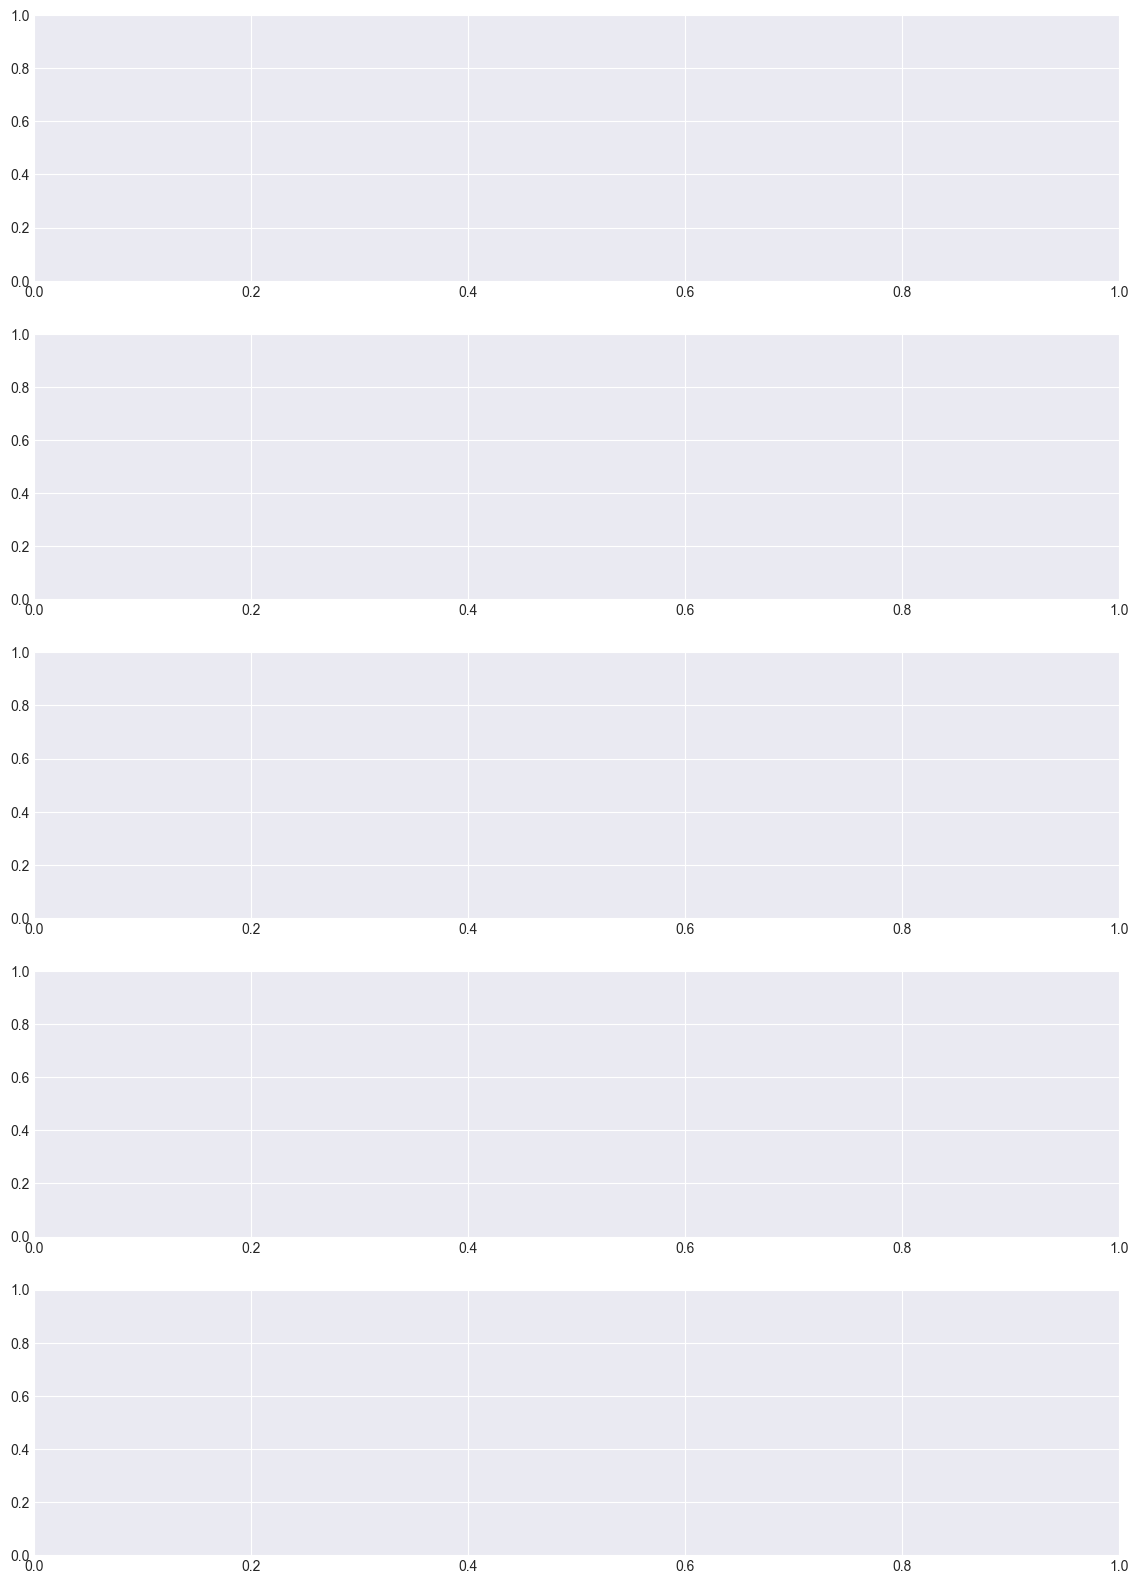

In [82]:
# ============================================================================
# PART 1B: UNIVARIATE ANALYSIS - CATEGORICAL VARIABLES
# ============================================================================
print("\n" + "="*80)
print("PART 1B: UNIVARIATE ANALYSIS - CATEGORICAL VARIABLES")
print("="*80)

# Categorical variables
n_cat = len(categorical_vars)
fig2, axes = plt.subplots(n_cat, 1, figsize=(14, n_cat*4))
if n_cat == 1:
    axes = [axes]

for idx, var in enumerate(categorical_vars):
    ax = axes[idx]
    # Drop NaN values

    value_counts = df[var].value_counts(dropna=True).sort_values(ascending=True)
    if len(value_counts) > 0:
        bars = ax.barh(range(len(value_counts)), value_counts.values, color='coral', edgecolor='black')
        ax.set_yticks(range(len(value_counts)))
        ax.set_yticklabels(value_counts.index, fontsize=10)
        ax.set_xlabel('Count', fontsize=11)
        ax.set_title(f'Distribution of {var} (missing={df[var].isna().sum()})',
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')

        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, value_counts.values)):
            ax.text(val, i, f' {val}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


## **Business Interpretation of categorical variable distributions:**

1. **Home Ownership:** The distribution of home ownership indicates that most borrowers have ongoing housing related financial obligations like rent or mortgage payments. From a credit perspective, housing costs are a major fixed expense that can affect repayment capacity. However, at this stage, the analysis is only descriptive, and does not imply differences in default risk yet.

2. **Loan Purpose:** Debt consolidation is the dominant loan purpose, which is typical for consumer lending platforms. This can indicate that many borrowers use personal loans to refinance existing high-interest debt, particularly credit cards. While this may improve short-term cash flow, it also can suggest elevated pre-existing debt levels, making loan purpose relevant for credit risk analysis.

3. **Verification Status:** Income verification is widely used across the portfolio, reflecting its role in improving the reliability of key financial metrics such as debt-to-income ratio. It can pottentially mean that Lending Club requires verification when borrower information raises uncertainty or potential risk concerns.

4. **Grade Distribution:** The grade distribution is concentrated in B and C grades, with fewer loans in the extreme categories (A and G). This pattern suggests a balanced risk strategy, where the platform does not focus exclusively on very low-risk borrowers, nor does it take excessive exposure to the highest-risk grades.

5. **Sub-Grade Distribution:** This additional granularity in sub-grades allows for more precise pricing, improved risk differentiation, and more accurate credit risk modelling at the portfolio level.


PART 2: LOGISTIC REGRESSION ANALYSIS

Logistic Regression Results:
      Variable  Coefficient  Odds Ratio  Intercept     N  Defaults  Default Rate
     loan_amnt     0.000019    1.000019  -1.719475 10129      1953      0.192813
      int_rate     0.125968    1.134246  -3.210231 10129      1953      0.192813
   installment     0.000509    1.000509  -1.663883 10129      1953      0.192813
    annual_inc    -0.000003    0.999997  -1.217078 10129      1953      0.192813
    emp_length     0.003463    1.003469  -1.452480 10129      1953      0.192813
           dti     0.029373    1.029809  -1.985511 10129      1953      0.192813
   delinq_2yrs     0.047178    1.048309  -1.448554 10129      1953      0.192813
inq_last_6mths     0.182065    1.199692  -1.560609 10129      1953      0.192813
      open_acc     0.006514    1.006535  -1.508181 10129      1953      0.192813
       pub_rec     0.153562    1.165980  -1.465853 10129      1953      0.192813
     revol_bal    -0.000003    0.999997  

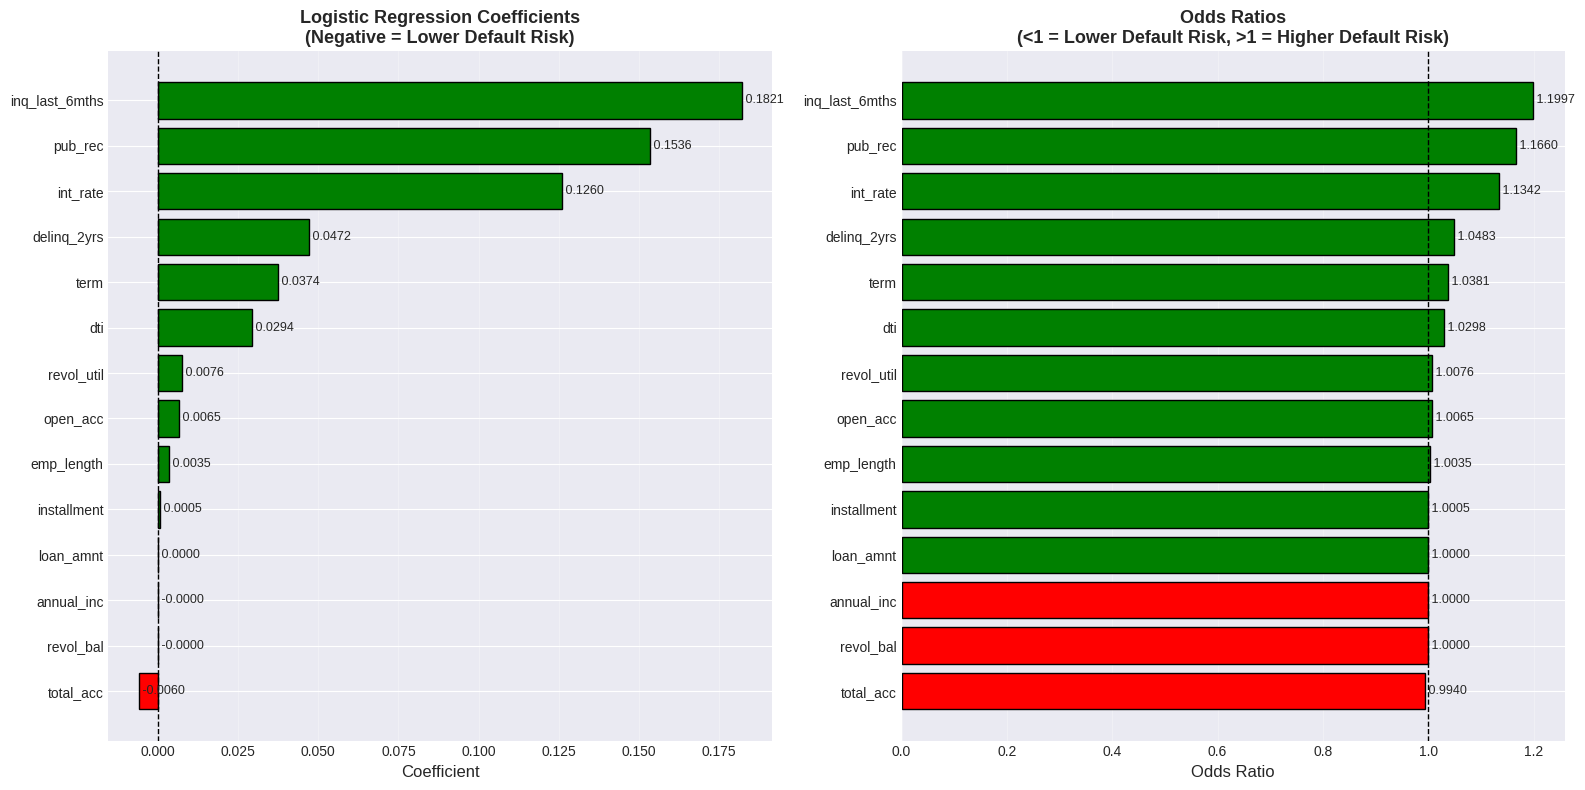

In [ ]:
# ============================================================================
# PART 2: LOGISTIC REGRESSION FOR NUMERICAL VARIABLES
# ============================================================================
print("\n" + "="*80)
print("PART 2: LOGISTIC REGRESSION ANALYSIS")
print("="*80)

logit_results = []

# Check if we have any defaults
if 'default' not in df.columns:
    print("\nERROR: 'default' column not found in dataset")
elif df['default'].isna().all():
    print("\nERROR: 'default' column contains only NaN values")
elif df['default'].sum() == 0:
    print("\nNOTE: No defaults in dataset - cannot fit logistic regression")
else:
    for var in numerical_vars:
        # Create a clean dataset without NaN for this variable
        mask = df[var].notna() & df['default'].notna()
        X = df.loc[mask, [var]]
        y = df.loc[mask, 'default']

        if len(X) > 10 and y.sum() > 0 and y.sum() < len(y):  # Need variation in y
            try:
                # Fit logistic regression
                model = LogisticRegression(max_iter=1000, solver='lbfgs')
                model.fit(X, y)

                # Get coefficient and odds ratio
                coef = model.coef_[0][0]
                odds_ratio = np.exp(coef)
                intercept = model.intercept_[0]

                logit_results.append({
                    'Variable': var,
                    'Coefficient': coef,
                    'Odds Ratio': odds_ratio,
                    'Intercept': intercept,
                    'N': len(X),
                    'Defaults': int(y.sum()),
                    'Default Rate': y.mean()
                })
            except Exception as e:
                print(f"  Warning: Could not fit model for {var}: {str(e)}")

# Create results dataframe
logit_df = pd.DataFrame(logit_results)

if len(logit_df) > 0:
    print("\nLogistic Regression Results:")
    print(logit_df.to_string(index=False))

    # Visualize coefficients
    fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plot coefficients
    sorted_df = logit_df.sort_values('Coefficient')
    colors = ['red' if x < 0 else 'green' for x in sorted_df['Coefficient']]
    ax1.barh(range(len(sorted_df)), sorted_df['Coefficient'], color=colors, edgecolor='black')
    ax1.set_yticks(range(len(sorted_df)))
    ax1.set_yticklabels(sorted_df['Variable'], fontsize=10)
    ax1.set_xlabel('Coefficient', fontsize=12)
    ax1.set_title('Logistic Regression Coefficients\n(Negative = Lower Default Risk)',
                  fontsize=13, fontweight='bold')
    ax1.axvline(0, color='black', linestyle='--', linewidth=1)
    ax1.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, val) in enumerate(zip(range(len(sorted_df)), sorted_df['Coefficient'])):
        ax1.text(val, i, f' {val:.4f}', va='center', fontsize=9)

    # Plot odds ratios
    sorted_df_or = logit_df.sort_values('Odds Ratio')
    colors_or = ['red' if x < 1 else 'green' for x in sorted_df_or['Odds Ratio']]
    ax2.barh(range(len(sorted_df_or)), sorted_df_or['Odds Ratio'], color=colors_or, edgecolor='black')
    ax2.set_yticks(range(len(sorted_df_or)))
    ax2.set_yticklabels(sorted_df_or['Variable'], fontsize=10)
    ax2.set_xlabel('Odds Ratio', fontsize=12)
    ax2.set_title('Odds Ratios\n(<1 = Lower Default Risk, >1 = Higher Default Risk)',
                  fontsize=13, fontweight='bold')
    ax2.axvline(1, color='black', linestyle='--', linewidth=1)
    ax2.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, val) in enumerate(zip(range(len(sorted_df_or)), sorted_df_or['Odds Ratio'])):
        ax2.text(val, i, f' {val:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo valid logistic regression results obtained")


## **Business Interpretation of the logistic regressions:**

*The logistic regression quantifies how each variable individually relates to default probability through coefficients and odds ratios.*

1. **Inquiries in Last 6 Months**: Each additional recent credit inquiry increases the odds of default by approximately 20%, making this the strongest predictor in the univariate analysis. Frequent credit inquiries signal increased credit-seeking behavior, often associated with short-term liquidity stress and financial instability.

2. **Public Records**: Each additional public record (such as bankruptcies or legal judgments) increases default odds by roughly 17%. This confirms that severe past credit events are highly predictive of future repayment problems and remain one of the most powerful traditional credit risk indicators.

3. **Interest Rate**: Higher interest rates are associated with higher default odds (+13% per percentage point). This reflects the lender’s risk-based pricing, where borrowers identified as riskier at origination are charged higher rates.

4. **Delinquencies in the Last 2 Years**: Each recent delinquency increases default odds by about 5%. Although the marginal effectis smaller than other variables, it reinforces the importance of recent payment behavior as an indicator of future default risk.

5. **Loan Term**: Longer loan terms are associated with modestly higher default odds (+4% per additional term unit). Longer maturities increase exposure time and may indicate borrowers selecting lower monthly payments due to tighter cash-flow constraints.

*The variables with the strongest univariate effects (inq_last_6mths, pub_rec, int_rate) align closely with earlier box plot findings. This consistency across descriptive and statistical methods increases confidence in identifying the most relevant drivers of default risk.*


PART 3: DEFAULT RATE BY CATEGORY

home_ownership:
                Default Rate  Defaults  Total
home_ownership                               
ANY                 0.000000         0      2
MORTGAGE            0.171108       854   4991
NONE                0.000000         0      1
OTHER               0.000000         0      2
OWN                 0.175218       181   1033
RENT                0.223902       918   4100

verification_status:
                     Default Rate  Defaults  Total
verification_status                               
Not Verified             0.135109       421   3116
Source Verified          0.209834       845   4027
Verified                 0.230074       687   2986

purpose:
                    Default Rate  Defaults  Total
purpose                                          
car                     0.111111        11     99
credit_card             0.160567       351   2186
debt_consolidation      0.209227      1229   5874
educational             0.333333         1  

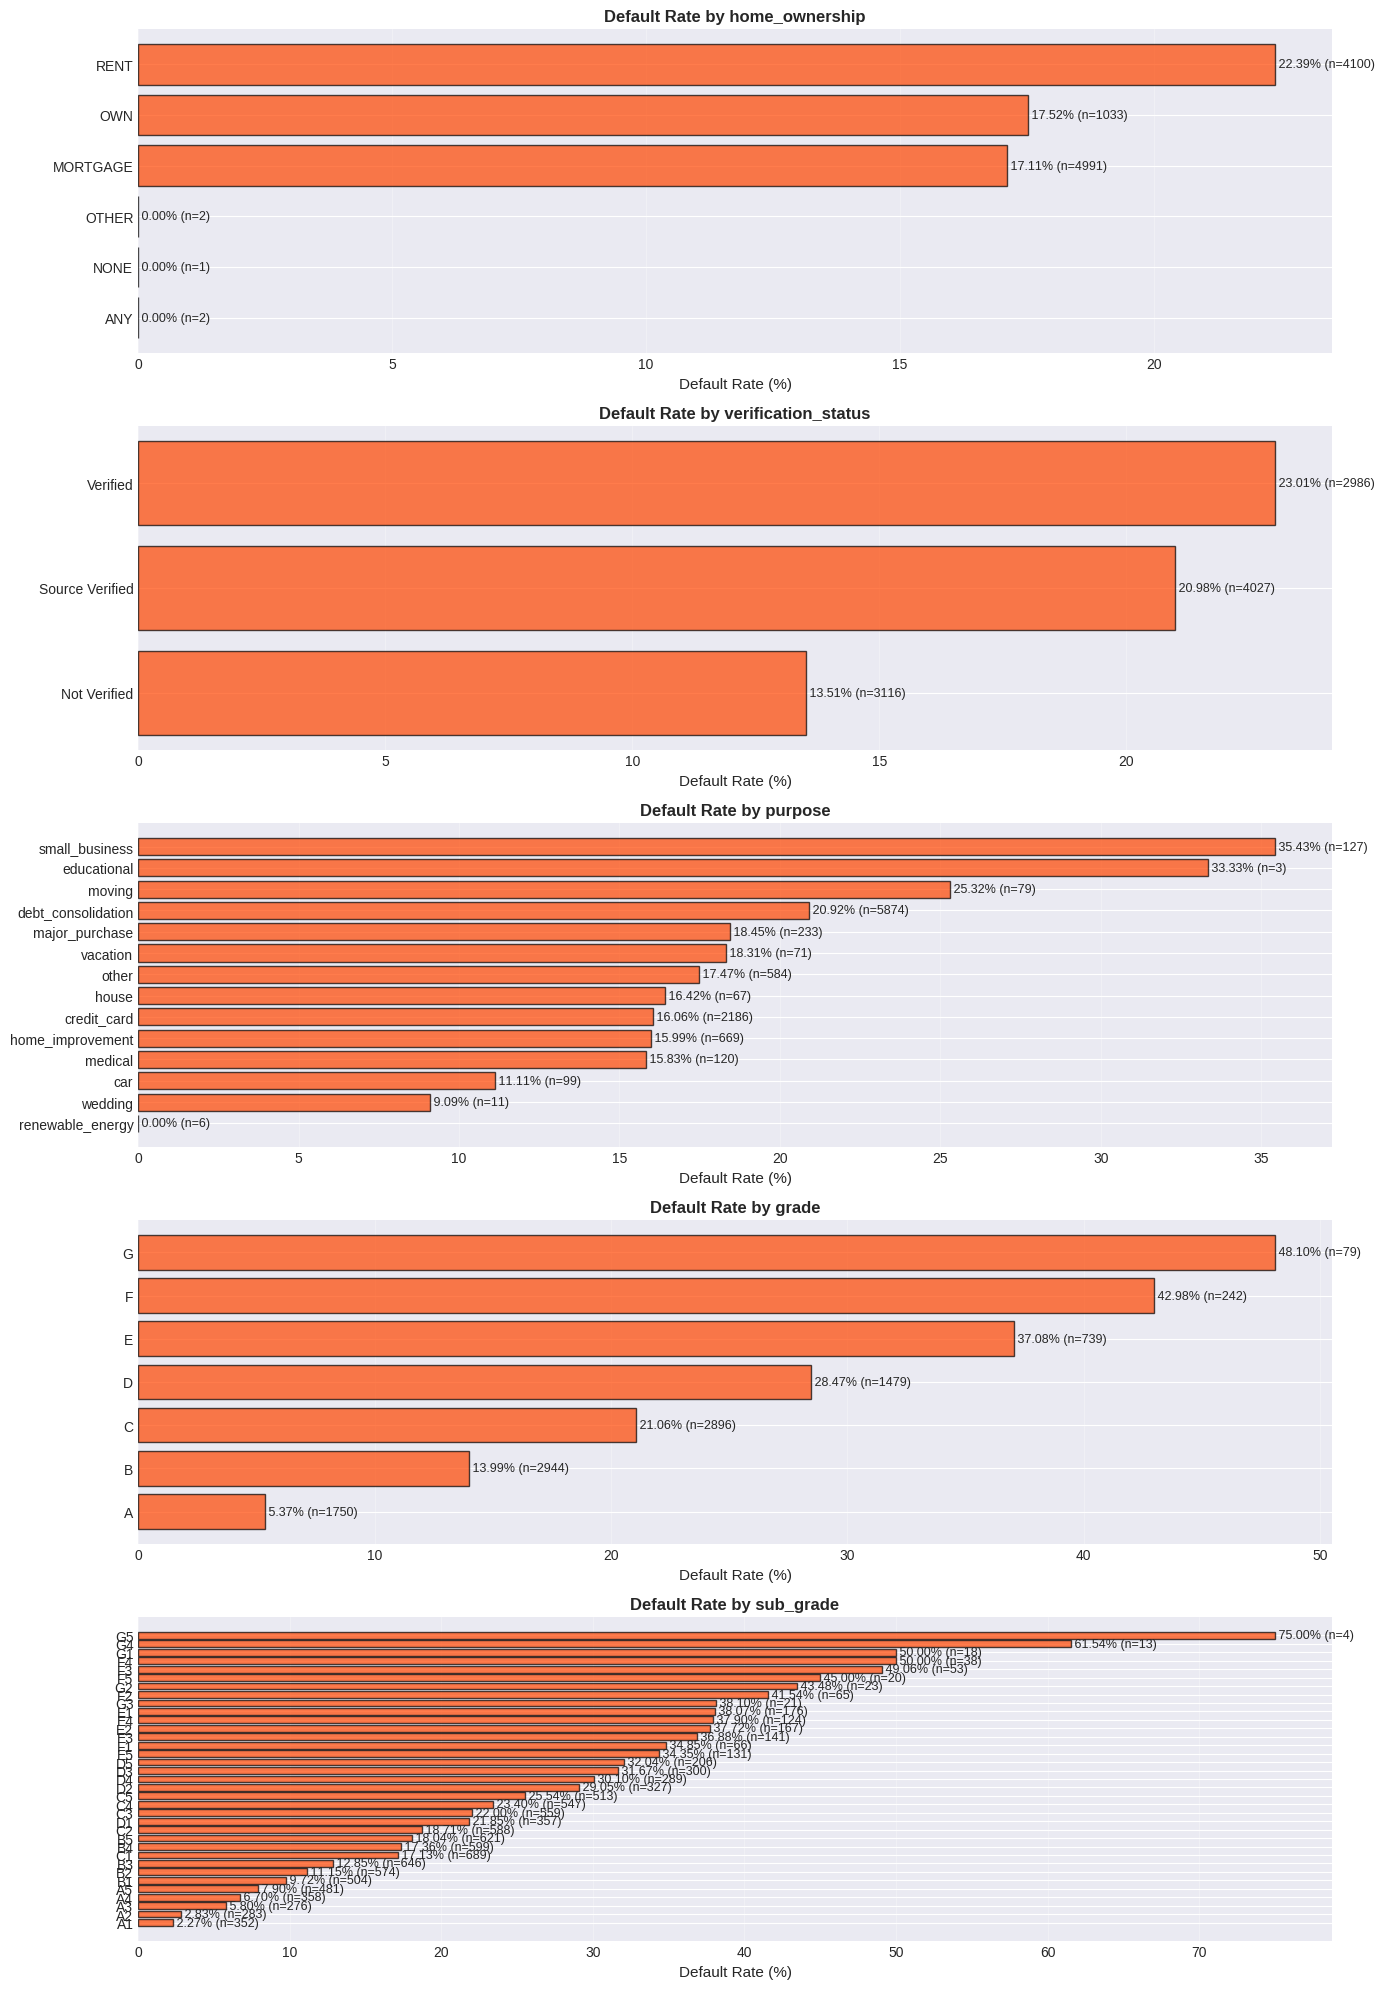

In [ ]:
# ============================================================================
# PART 3: DEFAULT RATE BY CATEGORY (CATEGORICAL VARIABLES)
# ============================================================================
print("\n" + "="*80)
print("PART 3: DEFAULT RATE BY CATEGORY")
print("="*80)

default_rate_results = []

if 'default' in df.columns and df['default'].notna().any():
    for var in categorical_vars:
        valid_mask = df[var].notna() & df['default'].notna()
        if valid_mask.sum() > 0:
            rates = df[valid_mask].groupby(var)['default'].agg(['mean', 'sum', 'count'])
            rates.columns = ['Default Rate', 'Defaults', 'Total']

            print(f"\n{var}:")
            print(rates.to_string())

            # Store results
            for category in rates.index:
                default_rate_results.append({
                    'Variable': var,
                    'Category': category,
                    'Default Rate': rates.loc[category, 'Default Rate'],
                    'Defaults': int(rates.loc[category, 'Defaults']),
                    'Total': int(rates.loc[category, 'Total'])
                })

    if len(default_rate_results) > 0:
        # Visualize default rates by category
        fig4, axes = plt.subplots(len(categorical_vars), 1, figsize=(14, len(categorical_vars)*4))
        if len(categorical_vars) == 1:
            axes = [axes]

        for idx, var in enumerate(categorical_vars):
            ax = axes[idx]

            valid_mask = df[var].notna() & df['default'].notna()
            if valid_mask.sum() > 0:
                var_data = df[valid_mask].groupby(var)['default'].agg(['mean', 'count']).reset_index()
                var_data.columns = ['Category', 'Default Rate', 'Count']
                var_data = var_data.sort_values('Default Rate', ascending=True)

                bars = ax.barh(range(len(var_data)), var_data['Default Rate']*100,
                               color='orangered', edgecolor='black', alpha=0.7)
                ax.set_yticks(range(len(var_data)))
                ax.set_yticklabels(var_data['Category'], fontsize=10)
                ax.set_xlabel('Default Rate (%)', fontsize=11)
                ax.set_title(f'Default Rate by {var}', fontsize=12, fontweight='bold')
                ax.grid(True, alpha=0.3, axis='x')

                # Add percentage labels and counts
                for i, (bar, rate, count) in enumerate(zip(bars, var_data['Default Rate'], var_data['Count'])):
                    label = f' {rate*100:.2f}% (n={int(count)})'
                    ax.text(rate*100, i, label, va='center', fontsize=9)

        plt.tight_layout()
        plt.show()
else:
    print("\nSkipped: Default rate analysis (no valid default data)")


## **Business Interpretation of default rates by categorical variables**

*This analysis shows actual default rates within each category, revealing which segments are riskiest.*

1. **Home Ownership:** The default rate varies meaningfully across home ownership categories, but renters exhibit the highest default rate at approximately 22.4%. This can suggest that homeownership is associated with greater financial stability and stronger underwriting signals.

2. **Verification Status:** Verification status shows a counter-intuitive pattern in which verified borrowers default more frequently than non-verified borrowers. It can reflect selection bias in the underwriting process, as income verification is more likely to be required when borrower information raises concerns. Consequently, verification status acts as a proxy for perceived risk at origination rather than a protective factor.

3. **Loan Purpose:** Small business loans display the highest default rate at approximately 35.4%, reflecting the inherent risk and volatility associated with business ventures. Debt consolidation loans, which make up the largest share of the portfolio, have a moderate default rate of around 21%. Credit card refinancing loans show lower default rates at approximately 16%, suggesting that these borrowers may be more proactive in managing existing debt.

4. **Grade:** Default rates increase progressivelly as grade quality deteriorates, ranging from approximately 5% (A) to nearly 48% (G). This steep and consistent gradient confirms that the grading system effectively captures underlying credit risk and provides a reliable basis for underwriting, pricing, and portfolio segmentation decisions.


PART 4: CORRELATION ANALYSIS

Correlations with Default:
int_rate          0.251016
term              0.169246
dti               0.102043
inq_last_6mths    0.073969
revol_util        0.072172
loan_amnt         0.068005
installment       0.054795
pub_rec           0.037639
delinq_2yrs       0.017844
open_acc          0.014867
emp_length        0.005045
revol_bal        -0.019908
total_acc        -0.027689
annual_inc       -0.046853


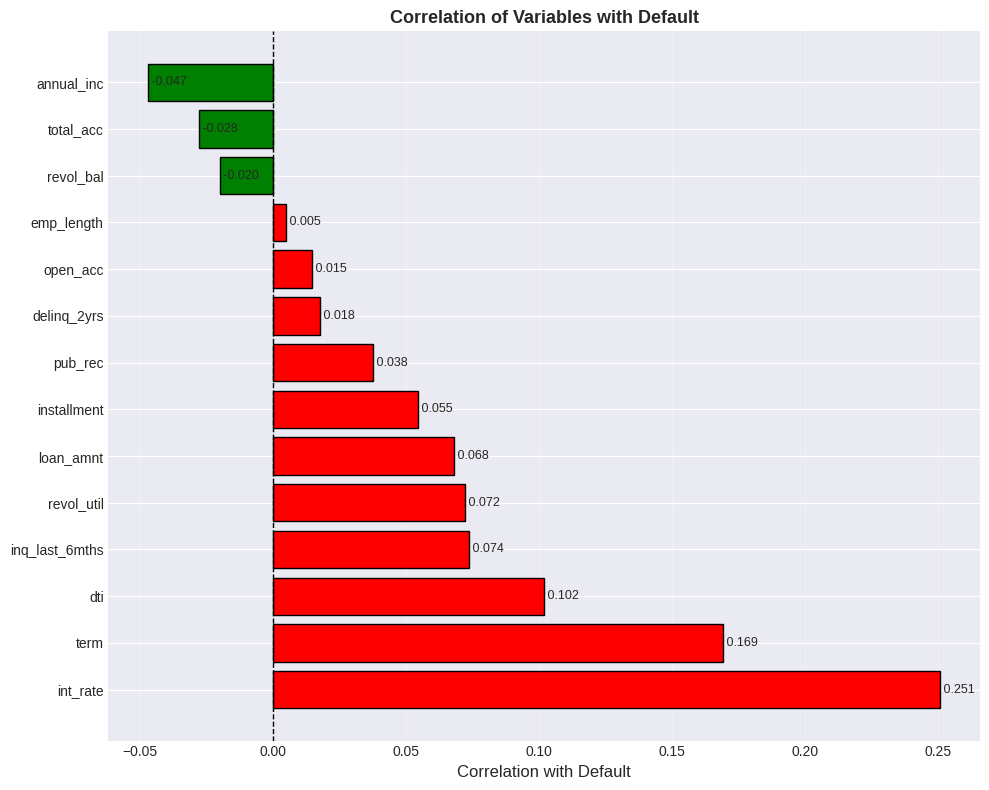

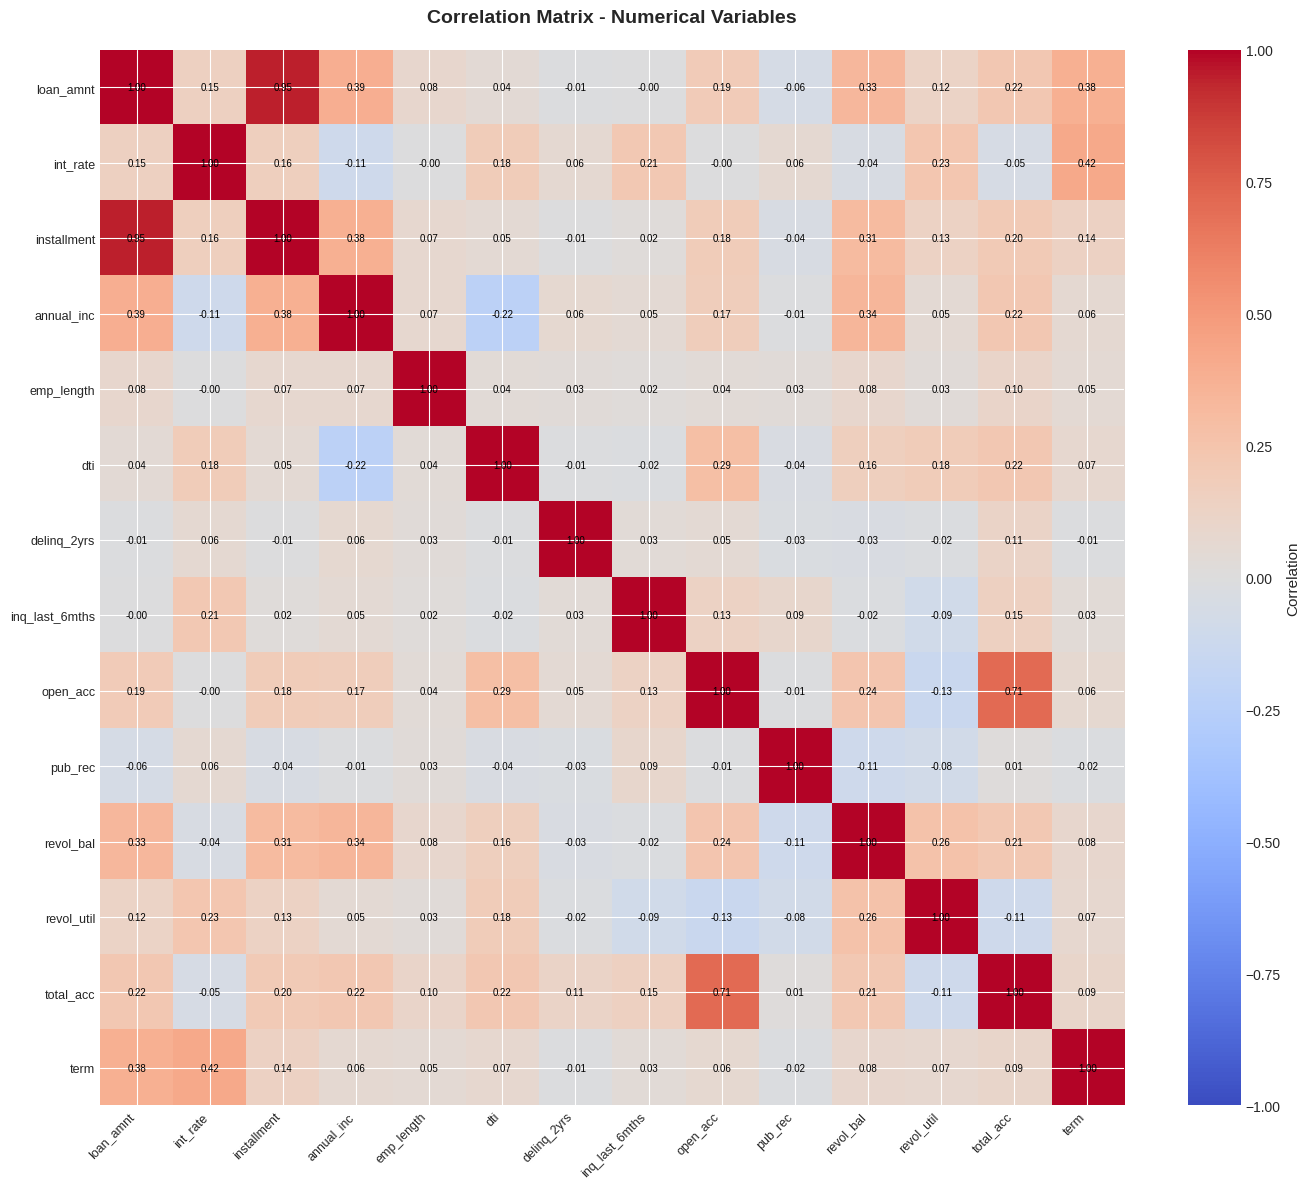

In [ ]:
# ============================================================================
# PART 4: CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("PART 4: CORRELATION ANALYSIS")
print("="*80)

# Create correlation matrix only with columns that have sufficient data
valid_num_vars = [var for var in numerical_vars if df[var].notna().sum() > 1]

if len(valid_num_vars) > 0 and 'default' in df.columns and df['default'].notna().sum() > 1:
    # Correlation with default
    correlations = df[valid_num_vars + ['default']].corr()['default'].drop('default').sort_values(ascending=False)
    print("\nCorrelations with Default:")
    print(correlations.to_string())

    fig5, ax = plt.subplots(figsize=(10, 8))
    colors = ['green' if x < 0 else 'red' for x in correlations.values]
    bars = ax.barh(range(len(correlations)), correlations.values, color=colors, edgecolor='black')
    ax.set_yticks(range(len(correlations)))
    ax.set_yticklabels(correlations.index, fontsize=10)
    ax.set_xlabel('Correlation with Default', fontsize=12)
    ax.set_title('Correlation of Variables with Default', fontsize=13, fontweight='bold')
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, correlations.values)):
        if not np.isnan(val):
            ax.text(val, i, f' {val:.3f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Full correlation matrix
    if len(valid_num_vars) > 1:
        fig6, ax = plt.subplots(figsize=(14, 12))
        corr_matrix = df[valid_num_vars].corr()
        im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax.set_xticks(range(len(valid_num_vars)))
        ax.set_yticks(range(len(valid_num_vars)))
        ax.set_xticklabels(valid_num_vars, rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(valid_num_vars, fontsize=9)
        ax.set_title('Correlation Matrix - Numerical Variables', fontsize=14, fontweight='bold', pad=20)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Correlation', fontsize=11)

        # Add correlation values
        for i in range(len(valid_num_vars)):
            for j in range(len(valid_num_vars)):
                val = corr_matrix.iloc[i, j]
                if not np.isnan(val):
                    text = ax.text(j, i, f'{val:.2f}',
                                  ha='center', va='center', color='black', fontsize=7)

        plt.tight_layout()
        plt.show()
else:
    print("\nSkipped: Correlation analysis (insufficient valid data)")


## **Business Interpretation of correlations**

*The correlation analysis quantifies linear relationships between each variable and default probability.*

1. **Strong Positive Correlations with Default**: Interest rate exhibits the strongest positive correlation with default, indicating that higher-priced loans are substantially more likely to default. Loan term and DTI ratio also show meaningful positive correlations, suggesting that longer maturities and higher leverage are associated with increased default risk.

2. **Moderate Positive Correlations with Default**: Recent credit inquiries, revolving credit utilization, public records, loan amount, and installment size show weaker but positive correlations with default. These variables capture aspects of financial stress, but their relatively low correlation values suggest that their effects on default are not strictly linear.

3. **Negative Correlations with Default**: Annual income displays a negative correlation with default, indicating that higher-income borrowers are slightly less likely to default. This protective effect is modest, reinforcing that income alone is not a strong standalone predictor without considering other risk factors.



PART 5: GRADE ANALYSIS

Default Rate by Grade:
       Default Rate  Defaults  Total
grade                               
A          0.053714        94   1750
B          0.139946       412   2944
C          0.210635       610   2896
D          0.284652       421   1479
E          0.370771       274    739
F          0.429752       104    242
G          0.481013        38     79


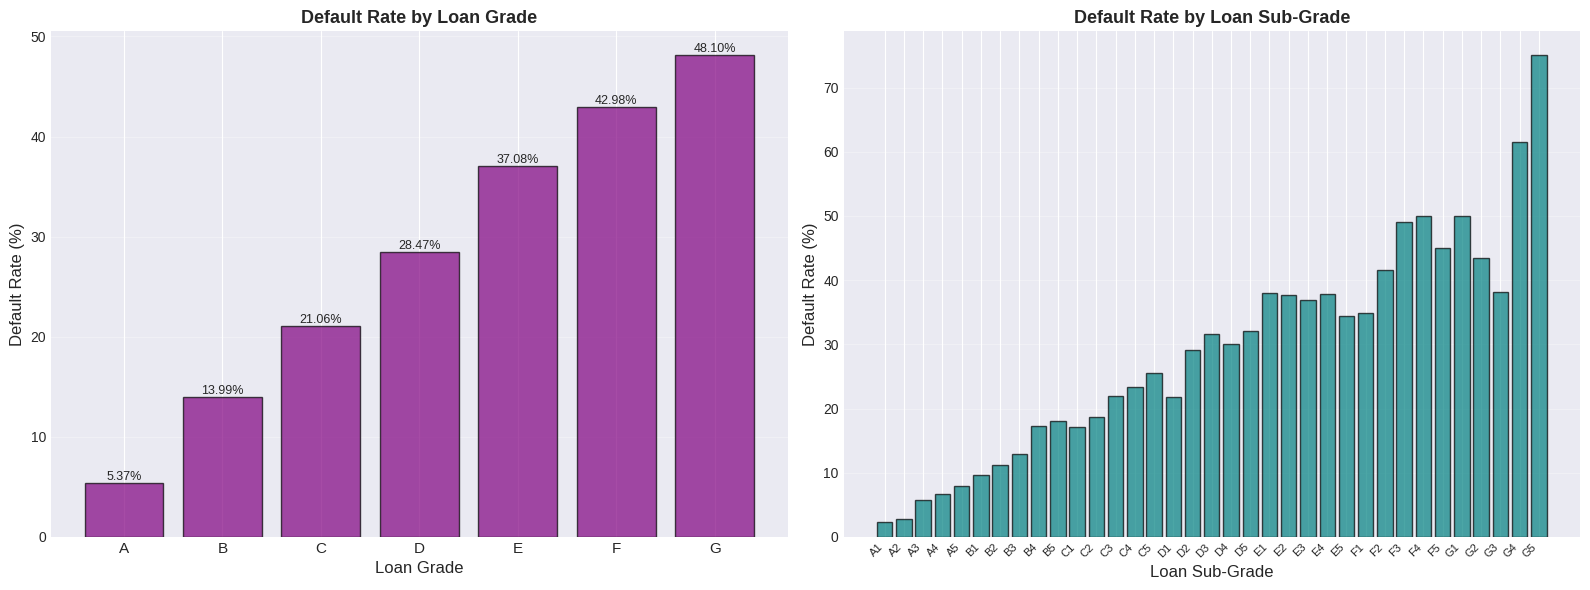

In [ ]:
# ============================================================================
# PART 5: GRADE ANALYSIS (Ordered Discrete Variable)
# ============================================================================
print("\n" + "="*80)
print("PART 5: GRADE ANALYSIS")
print("="*80)

if 'grade' in df.columns and 'default' in df.columns:
    # Define grade order
    grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    sub_grade_order = [f'{g}{i}' for g in grade_order for i in range(1, 6)]

    # Filter to only grades present in data
    valid_mask = df['grade'].notna() & df['default'].notna()
    if valid_mask.sum() > 0:
        grade_analysis = df[valid_mask].groupby('grade')['default'].agg(['mean', 'sum', 'count'])
        grade_analysis.columns = ['Default Rate', 'Defaults', 'Total']
        grade_analysis = grade_analysis.reindex([g for g in grade_order if g in grade_analysis.index])
        grade_analysis = grade_analysis.dropna(how='all')

        print("\nDefault Rate by Grade:")
        print(grade_analysis.to_string())

        fig7, axes = plt.subplots(1, 2, figsize=(16, 6))
        ax1, ax2 = axes

        # Grade analysis
        if len(grade_analysis) > 0:
            ax1.bar(range(len(grade_analysis)), grade_analysis['Default Rate']*100,
                    color='purple', edgecolor='black', alpha=0.7)
            ax1.set_xticks(range(len(grade_analysis)))
            ax1.set_xticklabels(grade_analysis.index, fontsize=11)
            ax1.set_xlabel('Loan Grade', fontsize=12)
            ax1.set_ylabel('Default Rate (%)', fontsize=12)
            ax1.set_title('Default Rate by Loan Grade', fontsize=13, fontweight='bold')
            ax1.grid(True, alpha=0.3, axis='y')

            for i, (grade, rate) in enumerate(zip(grade_analysis.index, grade_analysis['Default Rate'])):
                ax1.text(i, rate*100, f'{rate*100:.2f}%', ha='center', va='bottom', fontsize=9)

        # Sub-grade analysis
        if 'sub_grade' in df.columns:
            valid_mask2 = df['sub_grade'].notna() & df['default'].notna()
            if valid_mask2.sum() > 0:
                sub_grade_analysis = df[valid_mask2].groupby('sub_grade')['default'].agg(['mean', 'count'])
                sub_grade_analysis.columns = ['Default Rate', 'Count']
                present_sub_grades = [sg for sg in sub_grade_order if sg in sub_grade_analysis.index]
                sub_grade_analysis = sub_grade_analysis.reindex(present_sub_grades)
                sub_grade_analysis = sub_grade_analysis.dropna(how='all')

                if len(sub_grade_analysis) > 0:
                    ax2.bar(range(len(sub_grade_analysis)), sub_grade_analysis['Default Rate']*100,
                            color='teal', edgecolor='black', alpha=0.7)
                    ax2.set_xticks(range(len(sub_grade_analysis)))
                    ax2.set_xticklabels(sub_grade_analysis.index, rotation=45, ha='right', fontsize=8)
                    ax2.set_xlabel('Loan Sub-Grade', fontsize=12)
                    ax2.set_ylabel('Default Rate (%)', fontsize=12)
                    ax2.set_title('Default Rate by Loan Sub-Grade', fontsize=13, fontweight='bold')
                    ax2.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()
else:
    print("\nSkipped: Grade analysis (missing grade or default column)")


## **Business Interpretation of loan grades:**

**Loan grade:** Loan grade is the single most powerful predictor of default in the dataset, displaying an almost perfect relationship with realized default rates. The absence of irregularities confirms that Lending Club’s grading system ranks borrower risk accurately, making grade an extremely strong summary indicator of credit risk.

**Sub-grades:** They further refine risk differentiation. Default rates increase consistently acrossall sub-grades, reaching extremely high levels in the lowest sub-grades. This smooth progression indicates that sub-grades successfully capture incremental differences in borrower risk that are not visible at the broader grade level.

*Sample sizes decline sharply as grade risk increases, with thousands of observations in Grades B/C but fewer than 100 loans in Grade G. This reflects both reduced borrower demand and tighter underwriting standards for high-risk applicants. While default rates for the riskiest grades are strikingly high, the small sample sizes imply greater statistical uncertainty.*

In [83]:
# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nTotal observations: {len(df)}")
if 'default' in df.columns and df['default'].notna().any():
    print(f"Overall default rate: {df['default'].mean()*100:.2f}%")
    print(f"Total defaults: {int(df['default'].sum())}")
else:
    print("Default information not available")

# Return the logit results dataframe for further use
if len(logit_df) > 0:
    print("\nLogit regression results stored in 'logit_df' variable")
if len(default_rate_results) > 0:
    default_rate_df = pd.DataFrame(default_rate_results)
    print("Default rate results stored in 'default_rate_df' variable")


ANALYSIS COMPLETE

Total observations: 30000
Default information not available


NameError: name 'logit_df' is not defined

In [ ]:

import pandas as pd
import numpy as np
import sklearn

In [85]:
from sklearn.model_selection import train_test_split # Splits data set into random train/test subset.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder

RANDOM_STATE = 42

# -----------------------------
# Business cost table (industry-style assumptions)
# -----------------------------
# These values are simplified but realistic for unsecured consumer lending.
# They will be used to choose the classification threshold.

COST_FALSE_NEGATIVE = -10_000   # Approving a borrower who defaults (credit loss)
BENEFIT_TRUE_NEGATIVE = 1_500   # Approving a borrower who repays (interest income)
COST_FALSE_POSITIVE = -1_500    # Rejecting a good borrower (missed profit)
BENEFIT_TRUE_POSITIVE = 0       # Rejecting a bad borrower (no gain, no loss)



In [ ]:

import matplotlib.pyplot as plt


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", None) # We use this so that when calling head() all the columns are displayed



## **2. FEATURE ENGINEERING**

Creation and explanation of 10 engineered features.

In [111]:
# -----------------------------
# Load train and test data
# -----------------------------

TRAIN_PATH = "C:\\Users\\evzqn\\OneDrive\\Documents\\MiF 2025-2026\\Assignments\\Machine Learning\\lending_club_train.csv"
TEST_PATH = "C:\\Users\\evzqn\\OneDrive\\Documents\\MiF 2025-2026\\Assignments\\Machine Learning\\lending_club_test.csv"

train_df = pd.read_csv(TRAIN_PATH) # We are creating the train data frame
test_df = pd.read_csv(TEST_PATH) # We are creating the test data frame


## Engineered Feature Definitions

Let:

- \( L \) = loan amount  
- \( I \) = annual income  
- \( PMT \) = monthly installment  
- \( DTI \) = debt-to-income ratio  
- \( RB \) = revolving balance  
- \( RU \) = revolving utilization  
- \( OA \) = number of open accounts  
- \( r \) = interest rate  

---

### 1. Loan-to-Income Ratio
$$
\text{LoanToIncome} = \frac{L}{I}
$$

**Economic interpretation:**
Measures borrower leverage relative to income, capturing how large the loan is compared to repayment capacity (measured by income). Higher values imply greater exposure to income shocks and higher default risk.

**Outcome for the model:**
Provides an economically meaningful leverage measure that differentiates borrowers with similar loan sizes but different incomes, which is expected to help the model better rank default risk.

---

### 2. Installment-to-Income Ratio
$$
\text{InstallmentToIncome} = \frac{12 \cdot PMT}{I}
$$

**Economic interpretation:**
Captures the cash-flow burden imposed by the loan throughout periodic payments. Even borrowers with acceptable leverage can default if installments consume too much income.

**Outcome for the model:**
We expect that the metric enhances sensitivity to near-term financial stress and improving probability calibration.


---

### 3. Revolving Allowance per Account
$$
\text{RevAllowPerAcc} =
\frac{RB \cdot 100}{\max(RU,\,0.1) \cdot OA}
$$

**Economic interpretation:**
Revolving credit reflects short-term borrowing capacity and liquidity. The amount of revolving credit available per account indicates how much unused credit capacity remains relative to current usage.

**Outcome for the model:**
Helps distinguish borrowers with unused credit capacity from those operating close to limits.

---

### 4. DTI Including New Loan
$$
\text{DTI}_{\text{new}} =
DTI + \left( \frac{12 \cdot PMT}{I} \times 100 \right)
$$


**Economic interpretation:**
Represents the borrowers indebtedness by incorporating new loan into the borrower’s debt burden. The metric reflects on the true level of leverage after loan approval.

**Outcome for the model:**
Prevents underestimation of risk for borrowers whose pre-loan DTI appeared acceptable. With this new metric we expect to improve default probability estimation and overall model calibration.

---

### 5. Squared DTI
$$
\text{DTI}_{\text{squared}} = DTI^2
$$

**Economic interpretation:**

We add Squared DTI to introduce a nonlinear representation of indebtedness into the data. The raw DTI variable is a linear function. Squaring DTI changes this representation so that higher levels of indebtedness receive larger numerical weight than lower levels. Reflect that financial distress accelerates beyond critical leverage thresholds.

**Outcome for the model:**
Applies a deterministic nonlinear transformation to the existing DTI variable.

---

### 6. Log of Annual Income
$$
\log(\text{AnnualIncome}) = \ln(I)
$$

**Economic interpretation:**
Income reduces financial pressure, but an extra euro matters more for a low-income borrower than for a high-income borrower. Using the logarithm of income reflects this idea by focusing on relative income differences rather than absolute ones.

**Outcome for the model:**
We add the logarithm of income to rescale the income variable and reduce the dominance of very large values. This provides the model with an alternative, nonlinear representation of income using a deterministic transformation of the original data. Reduces right skewness and captures diminishing marginal effects of income.

---

### 7. Log of Interest Rate
$$
\log(\text{InterestRate}) = \ln(r)
$$
**Intuition:** Stabilizes variance and models nonlinear pricing effects of risk.

**Economic interpretation:**
The interest rate represents the cost of borrowing and reflects the risk assessment included in the loan contract. Differences in interest rates are more meaningful in relative terms than in absolute terms, especially when rates are already high.

**Outcome for the model:**
The logarithmic transformation is nonlinear because it rescales differences depending on the level of the interest rate, while remaining monotonic because it preserves the ordering of borrowers by borrowing costs.

---

### 8. DTI Z-score by Grade
$$
\text{DTI}_{z,g} =
\frac{DTI - \mu_{DTI,g}}{\sigma_{DTI,g}}
$$

**Economic rationale:**
Debt-to-income ratios are not interpreted in isolation but relative to the borrower's overall credit quality (using ratings). Borrowers within the same credit grade tend to have comparable risk profiles, so a given DTI level is best understood in relation to peers within the same grade.

**Outcome for the model:**
Standardizing DTI within each grade provides a relative measure of indebtedness that captures how a borrower's leverage compares to others in the same risk category. This adds contextual information to the model by expressing DTI on a grade-specific scale rather than as an absolute value.


---

### 9. Historical Delinquency Flag
$$
\text{HistDelinqFlag} =
\begin{cases}
1, & \text{if Delinq}_{2yrs} > 0 \ \text{or PubRec} > 0 \\
0, & \text{otherwise}
\end{cases}
$$

**Economic rationale:**
Past delinquency or public record events indicate that a borrower has previously experienced repayment difficulties or financial distress. Such events summarize adverse credit behavior observed before granting the loan. This metric might be usefull to bring this behaviour into the dataset.

**Outcome for the model:**
The binary flag condenses sparse and infrequent negative credit events into a single indicator, providing the model with a clear representation of whether any past credit distress has been observed.


---

### 10. Square Root of Loan Amount
$$
\text{SqrtLoanAmount} = \sqrt{L}
$$

**Economic rationale:**
Loan amount reflects the scale of the financial obligation. Very large loans differ mainly in magnitude rather than in kind, and absolute differences become less informative at higher levels.

**Outcome for the model:**
Applying a square-root transformation rescales the loan amount, reducing the influence of extreme values while preserving the ordering of loans by size.


In [112]:
# -----------------------------
# Feature engineering
# -----------------------------
# ============================================
# CREATING 10 NEW VARIABLES
# Apply the same transformations to train and test
# ============================================

# --- 1. LOAN TO INCOME ---
# Calculate what proportion of annual income the loan represents
# Formula: loan amount / annual income
train_df['loan_to_income'] = np.round(train_df['loan_amnt'] / train_df['annual_inc'],4)
test_df['loan_to_income'] = np.round(test_df['loan_amnt'] / test_df['annual_inc'],4)

# --- 2. INSTALLMENT TO INCOME ---
# Calculate what proportion of annual income goes to installments
# Formula: (monthly installment * 12 months) / annual income
train_df['installment_to_income'] = np.round((train_df['installment'] * 12) / train_df['annual_inc'],4)
test_df['installment_to_income'] = np.round((test_df['installment'] * 12) / test_df['annual_inc'],4)

# --- 3. REV ALLOW PER ACCOUNT ---
# Calculate the revolving limit allowed per account
# Formula: (Revolving Balance × 100 / Revolving Utilization) / Number of Accounts
train_df['rev_allow_per_acc'] = np.round((train_df['revol_bal'] * 100 / np.maximum(train_df['revol_util'],0.1)) / train_df['open_acc'],4)
test_df['rev_allow_per_acc'] = np.round((test_df['revol_bal'] * 100 / np.maximum(test_df['revol_util'],0.1)) / test_df['open_acc'],4)

# NP.MAXIMUM WITH 0.1 because some accounts have a utilisation of 0, giving them infinite allowance.
# This is not true, but we wanted to signal that not having any revolving debt is a positive sign, hence we assigned a value of 0.1 to give them a very high score.

# --- 4. DTI NEW LOAN ---
# Calculate DTI considering the new loan
# Formula: (Installment × 12 / Income) × 100 + DTI
train_df['dti_new_loan'] = np.round((train_df['installment'] * 12 / train_df['annual_inc']) * 100 + train_df['dti'],4)
test_df['dti_new_loan'] = np.round((test_df['installment'] * 12 / test_df['annual_inc']) * 100 + test_df['dti'],4)

# --- 5. DTI squared ---
# Higher DTI implies higher probability. Convex behaviour
train_df['dti_squared'] = train_df['dti']**2
test_df['dti_squared'] = test_df['dti']**2

# --- 6. Log(annual_inc) ---
# Right skewed and no negative values
train_df['log_annual_inc'] = np.log(train_df['annual_inc'])
test_df['log_annual_inc'] = np.log(test_df['annual_inc'])

# --- 7. Log(int_rate) ---
# Right skewed and no negative values
train_df['log_int_rate'] = np.log(train_df['int_rate'])
test_df['log_int_rate'] = np.log(test_df['int_rate'])

# --- 8. DTI_zscore_by_grade ---
grade_dti_stats = (
    train_df
    .groupby("grade")["dti"]
    .agg(dti_mean_by_grade="mean",# 1. Compute grade-level DTI statistics using TRAIN data only
         dti_std_by_grade="std")
    .reset_index()
)

def add_dti_zscore_by_grade(df, stats): # 2. Function to add the standardized DTI feature
    df = df.merge(stats, on="grade", how="left")
    df["dti_zscore_by_grade"] = (
        (df["dti"] - df["dti_mean_by_grade"]) /
        df["dti_std_by_grade"]
    )
    df.drop(columns=["dti_mean_by_grade", "dti_std_by_grade"], inplace=True)
    return df

train_df = add_dti_zscore_by_grade(train_df, grade_dti_stats)# 3. Apply consistently to all splits
test_df  = add_dti_zscore_by_grade(test_df,  grade_dti_stats)

# --- 9. Historical Delinquency Flag ---

train_df["historical_delinquency_flag"] = (
    (train_df["delinq_2yrs"] > 0) | (train_df["pub_rec"] > 0)# 1 if borrower had any delinquency in last 2 years OR any public record, else 0
).astype(int)

test_df["historical_delinquency_flag"] = (
    (test_df["delinq_2yrs"] > 0) | (test_df["pub_rec"] > 0)
).astype(int)

# --- 10. Square root of loan amount ---
train_df["sqrt_loan_amount"] = (
    (np.sqrt(train_df["loan_amnt"]))
).astype(float)

test_df["sqrt_loan_amount"] = (
    (np.sqrt(test_df["loan_amnt"]))
).astype(float)

# ============================================
# VERIFICATION: Check that columns were created correctly
# ============================================
print("New columns created in train_df:")
print(train_df[['loan_to_income', 'installment_to_income',
                'rev_allow_per_acc', 'dti_new_loan','dti_squared','log_annual_inc','log_int_rate','dti_zscore_by_grade','historical_delinquency_flag','sqrt_loan_amount']].head())

print("\nNew columns created in test_df:")
print(test_df[['loan_to_income', 'installment_to_income',
              'rev_allow_per_acc', 'dti_new_loan','dti_squared','log_annual_inc','log_int_rate','dti_zscore_by_grade','historical_delinquency_flag','sqrt_loan_amount']].head())

# We do this to show that this variables have been added to both the train and test data set.

X_full = train_df.drop(columns=["default", "id"])
y_full = train_df["default"]

X_test = test_df.drop(columns=["default", "id"])
y_test = test_df["default"]


New columns created in train_df:
   loan_to_income  installment_to_income  rev_allow_per_acc  dti_new_loan  \
0          0.3265                 0.0891          3431.6940       24.8536   
1          0.3987                 0.1566          3078.9557       55.6206   
2          0.1707                 0.0485          1923.3333       17.2841   
3          0.0857                 0.0331           577.5522       28.8369   
4          0.1562                 0.0430          2725.3966       17.7380   

   dti_squared  log_annual_inc  log_int_rate  dti_zscore_by_grade  \
0     254.0836       10.799576      2.564180            -0.331173   
1    1596.8016       10.545341      2.396986             2.789224   
2     154.5049       11.225243      2.696652            -0.826572   
3     651.7809       11.156251      2.277267             1.003699   
4     180.6336       11.472103      2.590017            -0.621099   

   historical_delinquency_flag  sqrt_loan_amount  
0                            0        

In [113]:
# -----------------------------
# Feature types
# -----------------------------

# We decided to move this part of the code here (below where it used to be)
# This way, the new features are:
# 1st: Added to both train and test data sets
# 2nd: Create X_full and X_test out of the train and test data sets, but with the new features included
# 3rd: Categorical and numerical features are defined with the new features already included


categorical_features = [
    "grade",
    "sub_grade",
    "home_ownership",
    "verification_status",
    "purpose"
]

numerical_features = [c for c in X_full.columns if c not in categorical_features]

In [114]:
# We check that the train data set has been properly updated with the new features.
train_df.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,annual_inc,emp_length,home_ownership,verification_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,purpose,default,loan_to_income,installment_to_income,rev_allow_per_acc,dti_new_loan,dti_squared,log_annual_inc,log_int_rate,dti_zscore_by_grade,historical_delinquency_flag,sqrt_loan_amount
0,79044496,16000.0,60.0,12.99,363.97,C,C2,49000.0,5.0,RENT,Source Verified,15.94,0.0,0.0,9.0,0.0,26376.0,85.4,19.0,debt_consolidation,0,0.3265,0.0891,3431.6940,24.8536,254.0836,10.799576,2.564180,-0.331173,0,126.491106
1,43246030,15150.0,36.0,10.99,495.92,B,B4,38000.0,8.0,MORTGAGE,Not Verified,39.96,1.0,1.0,10.0,0.0,19459.0,63.2,38.0,credit_card,0,0.3987,0.1566,3078.9557,55.6206,1596.8016,10.545341,2.396986,2.789224,1,123.085336
2,641694,12800.0,60.0,14.83,303.38,D,D3,75000.0,0.0,RENT,Source Verified,12.43,0.0,0.0,12.0,0.0,8078.0,35.0,13.0,moving,0,0.1707,0.0485,1923.3333,17.2841,154.5049,11.225243,2.696652,-0.826572,0,113.137085
3,70981628,6000.0,36.0,9.75,192.90,B,B3,70000.0,0.0,MORTGAGE,Verified,25.53,1.0,1.0,9.0,0.0,2048.0,39.4,16.0,debt_consolidation,0,0.0857,0.0331,577.5522,28.8369,651.7809,11.156251,2.277267,1.003699,1,77.459667
4,57792301,15000.0,60.0,13.33,343.84,C,C3,96000.0,3.0,RENT,Source Verified,13.44,0.0,0.0,11.0,1.0,15979.0,53.3,36.0,debt_consolidation,0,0.1562,0.0430,2725.3966,17.7380,180.6336,11.472103,2.590017,-0.621099,1,122.474487


In [115]:
# We check that the test data set has been properly updated with the new features.
test_df.head()


,id,loan_amnt,term,int_rate,installment,grade,sub_grade,annual_inc,emp_length,home_ownership,verification_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,purpose,default,loan_to_income,installment_to_income,rev_allow_per_acc,dti_new_loan,dti_squared,log_annual_inc,log_int_rate,dti_zscore_by_grade,historical_delinquency_flag,sqrt_loan_amount
0,21470611,5000.0,36.0,13.98,170.84,C,C3,40000.0,10.0,OWN,Source Verified,17.31,0.0,4.0,7.0,0.0,3379.0,86.6,17.0,home_improvement,1,0.1250,0.0513,557.4068,22.4352,299.6361,10.596635,2.637628,-0.172293,0,70.710678
1,86822388,8000.0,36.0,7.99,250.66,A,A4,70000.0,1.0,RENT,Source Verified,24.02,0.0,0.0,8.0,0.0,4381.0,16.5,14.0,other,0,0.1143,0.0430,3318.9394,28.3170,576.9604,11.156251,2.078191,1.134576,0,89.442719
2,7864600,6500.0,36.0,13.67,221.12,B,B5,23439.0,0.0,RENT,Verified,31.85,0.0,1.0,6.0,0.0,11636.0,71.8,9.0,debt_consolidation,0,0.2773,0.1132,2701.0214,43.1706,1014.4225,10.062157,2.615204,1.785717,0,80.622577
3,68745746,8775.0,36.0,7.49,272.92,A,A4,25000.0,0.0,RENT,Source Verified,34.48,0.0,0.0,9.0,0.0,16668.0,65.6,15.0,car,0,0.3510,0.1310,2823.1707,47.5802,1188.8704,10.126631,2.013569,2.524076,0,93.674970
4,46396814,10000.0,36.0,11.53,329.91,B,B5,56000.0,10.0,MORTGAGE,Not Verified,22.78,0.0,1.0,10.0,0.0,43943.0,87.7,21.0,credit_card,0,0.1786,0.0707,5010.6043,29.8495,518.9284,10.933107,2.444952,0.663422,0,100.000000


In [116]:
X_full["purpose"].value_counts()

purpose
debt_consolidation    5874
credit_card           2186
home_improvement       669
other                  584
major_purchase         233
small_business         127
medical                120
car                     99
moving                  79
vacation                71
house                   67
wedding                 11
renewable_energy         6
educational              3
Name: count, dtype: int64

In [117]:
# --------------------
# Categorical encoding (TRAIN)
# --------------------

# Fits OneHotEncoder on X_train and applies it to X_train and X_other

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_full_cat = encoder.fit_transform(X_full[categorical_features])
X_full_num = X_full[numerical_features]

X_full_enc = pd.DataFrame(np.hstack([X_full_num, X_full_cat]),
                           columns=X_full_num.columns.tolist() + encoder.get_feature_names_out(categorical_features).tolist())
X_full_enc.head(10)

,loan_amnt,term,int_rate,installment,annual_inc,emp_length,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,loan_to_income,installment_to_income,rev_allow_per_acc,dti_new_loan,dti_squared,log_annual_inc,log_int_rate,dti_zscore_by_grade,historical_delinquency_flag,sqrt_loan_amount,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,16000.0,60.0,12.99,363.97,49000.0,5.0,15.94,0.0,0.0,9.0,0.0,26376.0,85.4,19.0,0.3265,0.0891,3431.6940,24.8536,254.0836,10.799576,2.564180,-0.331173,0.0,126.491106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15150.0,36.0,10.99,495.92,38000.0,8.0,39.96,1.0,1.0,10.0,0.0,19459.0,63.2,38.0,0.3987,0.1566,3078.9557,55.6206,1596.8016,10.545341,2.396986,2.789224,1.0,123.085336,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12800.0,60.0,14.83,303.38,75000.0,0.0,12.43,0.0,0.0,12.0,0.0,8078.0,35.0,13.0,0.1707,0.0485,1923.3333,17.2841,154.5049,11.225243,2.696652,-0.826572,0.0,113.137085,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,6000.0,36.0,9.75,192.90,70000.0,0.0,25.53,1.0,1.0,9.0,0.0,2048.0,39.4,16.0,0.0857,0.0331,577.5522,28.8369,651.7809,11.156251,2.277267,1.003699,1.0,77.459667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15000.0,60.0,13.33,343.84,96000.0,3.0,13.44,0.0,0.0,11.0,1.0,15979.0,53.3,36.0,0.1562,0.0430,2725.3966,17.7380,180.6336,11.472103,2.590017,-0.621099,1.0,122.474487,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,15000.0,36.0,13.53,509.25,68000.0,10.0,28.85,0.0,0.0,7.0,0.0,24584.0,86.3,33.0,0.2206,0.0899,4069.5249,37.8368,832.3225,11.127263,2.604909,1.414506,0.0,122.474487,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,24000.0,36.0,6.39,734.38,170000.0,2.0,25.91,1.0,0.0,14.0,0.0,443859.0,69.3,30.0,0.1412,0.0518,45749.2270,31.0939,671.3281,12.043554,1.854734,1

In [118]:
# -----------------------------
# Create a validation set from the training data
# -----------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_full_enc,
    y_full,
    test_size=0.25, # We decided to stick to 1/4 of the train set.
    random_state=RANDOM_STATE
)

In [119]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7596, 89), (2533, 89), (7596,), (2533,))

In [120]:
X_val.head() # Check validation is also updated with the feature engineering

,loan_amnt,term,int_rate,installment,annual_inc,emp_length,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,loan_to_income,installment_to_income,rev_allow_per_acc,dti_new_loan,dti_squared,log_annual_inc,log_int_rate,dti_zscore_by_grade,historical_delinquency_flag,sqrt_loan_amount,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
8855,10800.0,36.0,17.27,386.51,38000.0,4.0,18.85,1.0,0.0,10.0,0.0,8308.0,59.8,21.0,0.2842,0.1221,1389.2977,31.0556,355.3225,10.545341,2.848971,-0.124762,1.0,103.923048,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532,35000.0,36.0,12.39,1169.04,110000.0,7.0,36.01,0.0,0.0,20.0,0.0,35303.0,48.2,45.0,0.3182,0.1275,3662.1369,48.7632,1296.7201,11.608236,2.516890,1.996358,0.0,187.082869,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1155,10000.0,60.0,14.49,235.24,245000.0,5.0,8.22,2.0,0.0,7.0,0.0,10471.0,49.4,17.0,0.0408,0.0115,3028.0509,9.3722,67.5684,12.409013,2.673459,-1.226466,1.0,100.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7769,12000.0,36.0,7.26,371.96,120000.0,0.0,7.45,1.0,0.0,15.0,0.0,3293.0,16.1,29.0,0.1000,0.0372,1363.5611,11.1696,55.5025,11.695247,1.982380,-1.066574,1.0,109.544512,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4922,9000.0,36.0,11.49,296.75,85500.0,10.0,11.86,0.0,2.0,6.0,0.0,6190.0,30.2,12.0,0.1053,0.0416,3416.1148,16.0249,140.6596,11.356272,2.441477,-0.687786,0.0,94.868330,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **3.1 FIRST ALGORITHM APPLIED**

Random Forest Model

In [121]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    #pip install matplotlib
    import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

In [122]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error

# To help reach our best AuC as fast as possible, we ran a few configurations, then focused our efforts near the strongest performer, in a smaller range. Then repeated.
# This runs the risk of getting stuck near a local maximum, however we tried running a huge range (np.arange) and it took us 3 hours, so we decided against doing this in future.
# Below you can see the BEST PERFORMING COMBINATION OF PARAMETERS for each iteration and their results.

#--------------------------------------------------------------------------
# HYPERPARAMETER ITERATION
#--------------------------------------------------------------------------

# max_depth_values = [5,9]
# min_samples_leaf_values = [1000,500]
# max_samples_values = [0.6, 0.9]
# max_features_values = [0.6, 0.9]
# n_estimators_values = [100, 1000]
# TOP PERFORMER WITH max_depth = 5, min_samples_leaf = 500, max_samples = 0.9, max_features = 0.6, n_estimators = 1000 (FIRST RUN) AUC_val = 0.694

# max_depth_values = [4,5,6] We try around 5 since best performer in previous run had that max_depth.
# min_samples_leaf_values = [400,500,600]
# max_samples_values = [0.8, 0.9]
# max_features_values = [0.6, 0.7]
# n_estimators_values = [750, 1000]
# TOP PERFORMER WITH max_depth = 6, min_samples_leaf = 400, max_samples = 0.9, max_features = 0.7, n_estimators = 1000 (SECOND RUN) AUC_val = 0.694

# max_depth_values = [6,7] We try around 6 since best performer in previous run had that max_depth.
# min_samples_leaf_values = [200,300,400]
# max_samples_values = [0.85, 0.9]
# max_features_values = [0.7, 0.8]
# n_estimators_values = [750, 1000]
# TOP PERFORMER WITH max_depth = 7, min_samples_leaf = 300, max_samples = 0.85, max_features = 0.7, n_estimators = 1000: (THIRD RUN) AUC = 0.695706

# max_depth_values = [7,8] We try around 7 since best performer in previous run had that max_depth.
# min_samples_leaf_values = [150,200,300]
# max_samples_values = [0.8, 0.85, 0.9]
# max_features_values = [0.7, 0.75]
# n_estimators_values = [1000]
# TOP PERFORMER WITH max_depth = 8, min_samples_leaf = 300, max_samples = 0.85, max_features = 0.70, n_estimators = 1000 (FOURTH RUN) AUC = 0.695709

# Very little improvement from third to fourth run, we have reached the point of diminishing returns.
# For this reason, we stick to these parameters and don't do any more runs.

max_depth_values = [7,8]
min_samples_leaf_values = [150,200,300]
max_samples_values = [0.8, 0.85, 0.9]
max_features_values = [0.7, 0.75]
n_estimators_values = [1000]

results = []

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        for max_samples in max_samples_values:
            for max_features in max_features_values:
                for n_estimators in n_estimators_values:
                    model = RandomForestClassifier(
                        max_depth=max_depth,
                        min_samples_leaf=min_samples_leaf,
                        max_samples=max_samples,
                        max_features=max_features,
                        n_estimators=n_estimators,
                        random_state=RANDOM_STATE,
                        n_jobs=-1
                    )

                    model.fit(X_train, y_train)

                    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
                    auc_train = roc_auc_score(y_train, y_train_pred_proba)
                    rmse_train = root_mean_squared_error(y_train, y_train_pred_proba)

                    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
                    auc_val = roc_auc_score(y_val, y_val_pred_proba)
                    rmse_val = root_mean_squared_error(y_val, y_val_pred_proba)

                    results.append({
                        "max_depth": max_depth,
                        "min_samples_leaf": min_samples_leaf,
                        "max_samples": max_samples,
                        "max_features": max_features,
                        "n_estimators": n_estimators,
                        "auc_val": auc_val,
                        "rmse_val": rmse_val,
                        "auc_train": auc_train,
                        "rmse_train": rmse_train
                    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="auc_val", ascending=False).head(10))
#print(results_df.sort_values(by="rmse_val", ascending=True).head(10)) #In case we want to see rmse, but we are not optimizing for it

    max_depth  min_samples_leaf  max_samples  max_features  n_estimators  \
32          8               300         0.85          0.70          1000   
14          7               300         0.85          0.70          1000   
8           7               200         0.85          0.70          1000   
15          7               300         0.85          0.75          1000   
33          8               300         0.85          0.75          1000   
26          8               200         0.85          0.70          1000   
27          8               200         0.85          0.75          1000   
25          8               200         0.80          0.75          1000   
9           7               200         0.85          0.75          1000   
34          8               300         0.90          0.70          1000   

     auc_val  rmse_val  auc_train  rmse_train  
32  0.695709  0.391095   0.707941    0.374056  
14  0.695706  0.391095   0.707945    0.374056  
8   0.695538  0.390

In [123]:
# -----------------------------
# Find best hyperparameters
# -----------------------------
# Identify the (max_depth, min_samples_leaf) combination
# that MAXIMIZES validation RMSE.

best_row = results_df.loc[results_df["auc_val"].idxmax()]
print("\nBest hyperparameters based on validation RMSE:")
print(best_row)

# -----------------------------
# Select final model
# -----------------------------
# Re-train a Decision Tree using the best hyperparameters
# found above, and use it as your candidate model.

best_model = RandomForestClassifier(
    max_depth=int(best_row["max_depth"]),
    min_samples_leaf=int(best_row["min_samples_leaf"]),
    max_samples=float(best_row["max_samples"]),
    max_features=float(best_row["max_features"]),
    n_estimators=int(best_row["n_estimators"]),
    random_state=RANDOM_STATE,
                        n_jobs=-1
                    )

best_model.fit(X_train, y_train)

y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_rmse = root_mean_squared_error(y_train, y_train_pred_proba)
train_auc = roc_auc_score(y_train, y_train_pred_proba)

#print("Train RMSE:", train_rmse)
print("Train AUC:", train_auc)


Best hyperparameters based on validation RMSE:
max_depth              8.000000
min_samples_leaf     300.000000
max_samples            0.850000
max_features           0.700000
n_estimators        1000.000000
auc_val                0.695709
rmse_val               0.391095
auc_train              0.707941
rmse_train             0.374056
Name: 32, dtype: float64
Train AUC: 0.707940947013944


Tested 91 different thresholds
OPTIMAL THRESHOLD FOUND!

Optimal threshold: 0.20
   Total profit on validation set: $-1,048,500
   Average profit per loan: $-413.94

Default threshold (0.50):
   Total profit on validation set: $-2,295,500
   Average profit per loan: $-906.24

Improvement: $1,247,000 (+54.3%)


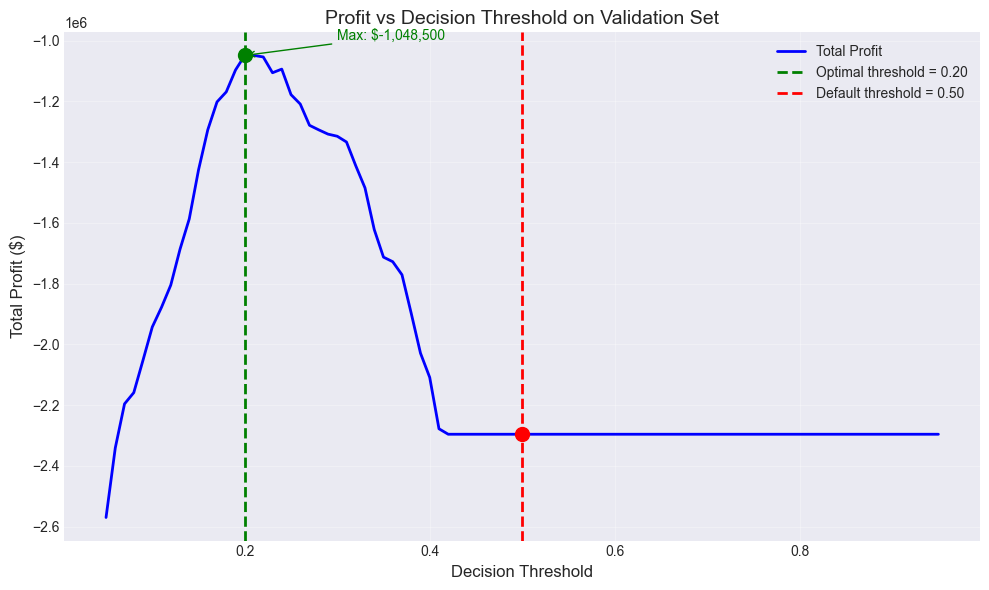

[[1282  721]
 [ 189  341]]


In [124]:
# Step 2: Calculate profit for each threshold on the VALIDATION set

from sklearn.metrics import confusion_matrix

# We'll use the validation set to find the optimal threshold
# (Never optimize on the test set!)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Test thresholds from 0.05 to 0.95 in small steps
thresholds = np.arange(0.05, 0.96, 0.01)

# Store results for each threshold
threshold_results = []

for threshold in thresholds:
    # Convert probabilities to binary predictions using this threshold
    y_pred = (y_val_pred_proba >= threshold).astype(int)

    # Get confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    # Calculate total profit
    total_profit = (
        tn * BENEFIT_TRUE_NEGATIVE +
        tp * BENEFIT_TRUE_POSITIVE +
        fp * COST_FALSE_POSITIVE +
        fn * COST_FALSE_NEGATIVE
    )

    threshold_results.append({
        'threshold': threshold,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'total_profit': total_profit,
        'avg_profit_per_loan': total_profit / len(y_val)
    })

# Convert to DataFrame for easy analysis
threshold_df = pd.DataFrame(threshold_results)
print(f"Tested {len(thresholds)} different thresholds")
threshold_df.head(10)
# Find the threshold with maximum profit
optimal_idx = threshold_df['total_profit'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_profit = threshold_df.loc[optimal_idx, 'total_profit']

# Compare with default threshold of 0.5
default_row = threshold_df[threshold_df['threshold'].round(2) == 0.50].iloc[0]
default_profit = default_row['total_profit']

print("=" * 60)
print("OPTIMAL THRESHOLD FOUND!")
print("=" * 60)
print(f"\nOptimal threshold: {optimal_threshold:.2f}")
print(f"   Total profit on validation set: ${optimal_profit:,.0f}")
print(f"   Average profit per loan: ${optimal_profit/len(y_val):,.2f}")
print()
print(f"Default threshold (0.50):")
print(f"   Total profit on validation set: ${default_profit:,.0f}")
print(f"   Average profit per loan: ${default_profit/len(y_val):,.2f}")
print()
print(f"Improvement: ${optimal_profit - default_profit:,.0f} ({(optimal_profit - default_profit)/abs(default_profit)*100:+.1f}%)")
# Visualize profit vs threshold
plt.figure(figsize=(10, 6))

plt.plot(threshold_df['threshold'], threshold_df['total_profit'],
         linewidth=2, color='blue', label='Total Profit')

# Mark the optimal threshold
plt.axvline(x=optimal_threshold, color='green', linestyle='--', linewidth=2,
            label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.scatter([optimal_threshold], [optimal_profit], color='green', s=100, zorder=5)

# Mark the default threshold (0.5)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2,
            label='Default threshold = 0.50')
plt.scatter([0.5], [default_profit], color='red', s=100, zorder=5)

plt.xlabel('Decision Threshold', fontsize=12)
plt.ylabel('Total Profit ($)', fontsize=12)
plt.title('Profit vs Decision Threshold on Validation Set', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Add annotations
plt.annotate(f'Max: ${optimal_profit:,.0f}',
             xy=(optimal_threshold, optimal_profit),
             xytext=(optimal_threshold + 0.1, optimal_profit + 50000),
             fontsize=10, color='green',
             arrowprops=dict(arrowstyle='->', color='green'))

plt.tight_layout()
plt.show()
print(confusion_matrix(y_val, (y_val_pred_proba >= optimal_threshold).astype(int)))

In [125]:
# -----------------------------
# Encode test data (DO NOT refit encoder)
# -----------------------------

X_test_cat = encoder.transform(X_test[categorical_features])
X_test_num = X_test[numerical_features].values
X_test_enc = pd.DataFrame(np.hstack([X_test_num, X_test_cat]),
                                  columns=numerical_features +
                                  encoder.get_feature_names_out(
                                      categorical_features).tolist())

# -----------------------------
# Test set evaluation (used ONCE)
# -----------------------------

y_test_pred_proba = best_model.predict_proba(X_test_enc)[:, 1]
test_rmse = root_mean_squared_error(y_test, y_test_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Test ROC-AUC: {test_auc:.3f}")
#print(f"Test RMSE: {test_rmse:.3f}")

# Test AuC ends up being 0.712, a little better than our validation set and in line with our training set.
# A pleasant surprise, and shows the model performs well with new data.

Test ROC-AUC: 0.713


# **3.2 SECOND ALGORITHM APPLIED**

Gradient Boosting Model

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

In [127]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error

# To help reach our best AuC as fast as possible, we ran a few configurations, then focused our efforts near the strongest performer, in a smaller range. Then repeated.
# This runs the risk of getting stuck near a local maximum, however we tried running a huge range (np.arange) and it took us 3 hours, so we decided against doing this in future.
# Below you can see the iterations and their results.

#--------------------------------------------------------------------------
# HYPERPARAMETER ITERATION
#--------------------------------------------------------------------------

#max_depth_values = [5,9]
#min_samples_leaf_values = [1000, 500]
#subsample_values = [0.6, 0.9]
#max_features_values = [0.6, 0.9]
#learning_rate_values = [0.1, 0.001]
# TOP PERFORMER WITH max_depth_values = 5, min_samples_leaf_values = 1000, subsample_values = 0.9, max_features_values = 0.6, learning_rate_values = 0.1 (FIRST RUN) AUC_val = 0.702205

#max_depth_values = [4,5]
#min_samples_leaf_values = [1000, 1250]
#subsample_values = [0.8, 0.9]
#max_features_values = [0.6, 0.7]
#learning_rate_values = [0.1, 0.05]
# TOP PERFORMER WITH max_depth_values = 4, min_samples_leaf_values = 1000, subsample_values = 0.8, max_features_values = 0.6, learning_rate_values = 0.05 (SECOND RUN) AUC_val =  0.706354

#max_depth_values = [3,4]
#min_samples_leaf_values = [900, 1000]
#subsample_values = [0.8, 0.7]
#max_features_values = [0.5, 0.6]
#learning_rate_values = [0.03, 0.05]
# TOP PERFORMER WITH max_depth_values = 4, min_samples_leaf_values = 1000, subsample_values = 0.8, max_features_values = 0.6, learning_rate_values = 0.05 (THIRD RUN) AUC_val =  0.706354
# No change between second and third run.


max_depth_values = [3,4]
min_samples_leaf_values = [900, 1000]
subsample_values = [0.8, 0.7]
max_features_values = [0.5, 0.6]
learning_rate_values = [0.03, 0.05]

results = []

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        for subsample in subsample_values:
            for max_features in max_features_values:
                for learning_rate in learning_rate_values:
                    model = GradientBoostingClassifier(
                        max_depth=max_depth,
                        min_samples_leaf=min_samples_leaf,
                        subsample=subsample,
                        max_features=max_features,
                        learning_rate=learning_rate,
                        n_estimators=10000,
                        validation_fraction=0.1,
                        n_iter_no_change=10,
                        verbose=0,
                        random_state=RANDOM_STATE
                    )

                    model.fit(X_train, y_train)

                    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
                    auc_train = roc_auc_score(y_train, y_train_pred_proba)
                    rmse_train = root_mean_squared_error(y_train, y_train_pred_proba)

                    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
                    auc_val = roc_auc_score(y_val, y_val_pred_proba)
                    rmse_val = root_mean_squared_error(y_val, y_val_pred_proba)

                    results.append({
                        "max_depth": max_depth,
                        "min_samples_leaf": min_samples_leaf,
                        "subsample": subsample,
                        "max_features": max_features,
                        "learning_rate": learning_rate,
                        "auc_val": auc_val,
                        "rmse_val": rmse_val,
                        "auc_train": auc_train,
                        "rmse_train": rmse_train
                    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="auc_val", ascending=False).head(10))
#print(results_df.sort_values(by="rmse_val", ascending=True).head(10)) #In case we want to see rmse, but we are not optimizing for it

    max_depth  min_samples_leaf  subsample  max_features  learning_rate  \
27          4              1000        0.8           0.6           0.05   
11          3              1000        0.8           0.6           0.05   
10          3              1000        0.8           0.6           0.03   
24          4              1000        0.8           0.5           0.03   
25          4              1000        0.8           0.5           0.05   
9           3              1000        0.8           0.5           0.05   
8           3              1000        0.8           0.5           0.03   
18          4               900        0.8           0.6           0.03   
13          3              1000        0.7           0.5           0.05   
29          4              1000        0.7           0.5           0.05   

     auc_val  rmse_val  auc_train  rmse_train  
27  0.706354  0.388728   0.712142    0.372704  
11  0.705675  0.388826   0.712347    0.372678  
10  0.704746  0.389094   0.710

In [128]:
# -----------------------------
# Find best hyperparameters
# -----------------------------
# Identify the (max_depth, min_samples_leaf) combination
# that MINIMIZES validation AuC.

best_row = results_df.loc[results_df["auc_val"].idxmax()]
print("\nBest hyperparameters based on validation AuC:")
print(best_row)

# -----------------------------
# Select final model
# -----------------------------
# Re-train a Decision Tree using the best hyperparameters
# found above, and use it as your candidate model.

best_model = GradientBoostingClassifier(
    max_depth=int(best_row["max_depth"]),
    min_samples_leaf=int(best_row["min_samples_leaf"]),
    subsample=best_row["subsample"],
    max_features=best_row["max_features"],
    learning_rate=best_row["learning_rate"],
    n_estimators=10000,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=0,
    random_state=RANDOM_STATE)

best_model.fit(X_train, y_train)

y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
train_rmse = root_mean_squared_error(y_train, y_train_pred_proba)
train_auc = roc_auc_score(y_train, y_train_pred_proba)

#print("Train RMSE:", train_rmse) #In case we want to see rmse, but we are not optimizing for it
print("Train AUC:", train_auc)



Best hyperparameters based on validation AuC:
max_depth              4.000000
min_samples_leaf    1000.000000
subsample              0.800000
max_features           0.600000
learning_rate          0.050000
auc_val                0.706354
rmse_val               0.388728
auc_train              0.712142
rmse_train             0.372704
Name: 27, dtype: float64
Train AUC: 0.7121423072093589


In [129]:
# -----------------------------
# Encode test data (DO NOT refit encoder)
# -----------------------------

X_test_cat = encoder.transform(X_test[categorical_features])
X_test_num = X_test[numerical_features].values
X_test_enc = pd.DataFrame(np.hstack([X_test_num, X_test_cat]),
                                  columns=numerical_features +
                                  encoder.get_feature_names_out(
                                      categorical_features).tolist())

# -----------------------------
# Test set evaluation (used ONCE)
# -----------------------------

y_test_pred_proba = best_model.predict_proba(X_test_enc)[:, 1]
test_rmse = root_mean_squared_error(y_test, y_test_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Test ROC-AUC: {test_auc:.3f}")
# print(f"Test RMSE: {test_rmse:.3f}") #In case we want to see rmse, but we are not optimizing for it

# Test AuC ends up being 0.712, a little better than our validation set and in line with our training set.
# This shows the model performs well with new data, however in terms of AuC, not any better than the random forest, which is curious.

Test ROC-AUC: 0.713


In [130]:
from sklearn.metrics import confusion_matrix

# We'll use the validation set to find the optimal threshold
# (Never optimize on the test set!)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Test thresholds from 0.05 to 0.95 in small steps
thresholds = np.arange(0.05, 0.96, 0.01)

# Store results for each threshold
threshold_results = []

for threshold in thresholds:
    # Convert probabilities to binary predictions using this threshold
    y_pred = (y_val_pred_proba >= threshold).astype(int)

    # Get confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    # Calculate total profit
    total_profit = (
        tn * BENEFIT_TRUE_NEGATIVE +
        tp * BENEFIT_TRUE_POSITIVE +
        fp * COST_FALSE_POSITIVE +
        fn * COST_FALSE_NEGATIVE
    )

    threshold_results.append({
        'threshold': threshold,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'total_profit': total_profit,
        'avg_profit_per_loan': total_profit / len(y_val)
    })

# Convert to DataFrame for easy analysis
threshold_df = pd.DataFrame(threshold_results)
print(f"Tested {len(thresholds)} different thresholds")
threshold_df.head(10)

Tested 91 different thresholds


,threshold,TP,TN,FP,FN,total_profit,avg_profit_per_loan
0,0.05,528,44,1959,2,-2892500,-1141.926569
1,0.06,519,175,1828,11,-2589500,-1022.305567
2,0.07,507,307,1696,23,-2313500,-913.343861
3,0.08,500,399,1604,30,-2107500,-832.017371
4,0.09,492,463,1540,38,-1995500,-787.801026
5,0.10,486,544,1459,44,-1812500,-715.554678
6,0.11,477,601,1402,53,-1731500,-683.576786
7,0.12,468,667,1336,62,-1623500,-640.939597
8,0.13,455,748,1255,75,-1510500,-596.328464
9,0.14,443,825,1178,87,-1399500,-552.506909


In [131]:
# Find the threshold with maximum profit
optimal_idx = threshold_df['total_profit'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_profit = threshold_df.loc[optimal_idx, 'total_profit']

# Compare with default threshold of 0.5
default_row = threshold_df[threshold_df['threshold'].round(2) == 0.50].iloc[0]
default_profit = default_row['total_profit']

print("=" * 60)
print("OPTIMAL THRESHOLD FOUND!")
print("=" * 60)
print(f"\nOptimal threshold: {optimal_threshold:.2f}")
print(f"   Total profit on Validation set: ${optimal_profit:,.0f}")
print(f"   Average profit per loan: ${optimal_profit/len(y_val):,.2f}")
print()
print(f"Default threshold (0.50):")
print(f"   Total profit on validation set: ${default_profit:,.0f}")
print(f"   Average profit per loan: ${default_profit/len(y_val):,.2f}")
print()
print(f"Improvement: ${optimal_profit - default_profit:,.0f} ({(optimal_profit - default_profit)/abs(default_profit)*100:+.1f}%)")

OPTIMAL THRESHOLD FOUND!

Optimal threshold: 0.18
   Total profit on Validation set: $-915,500
   Average profit per loan: $-361.43

Default threshold (0.50):
   Total profit on validation set: $-2,295,500
   Average profit per loan: $-906.24

Improvement: $1,380,000 (+60.1%)


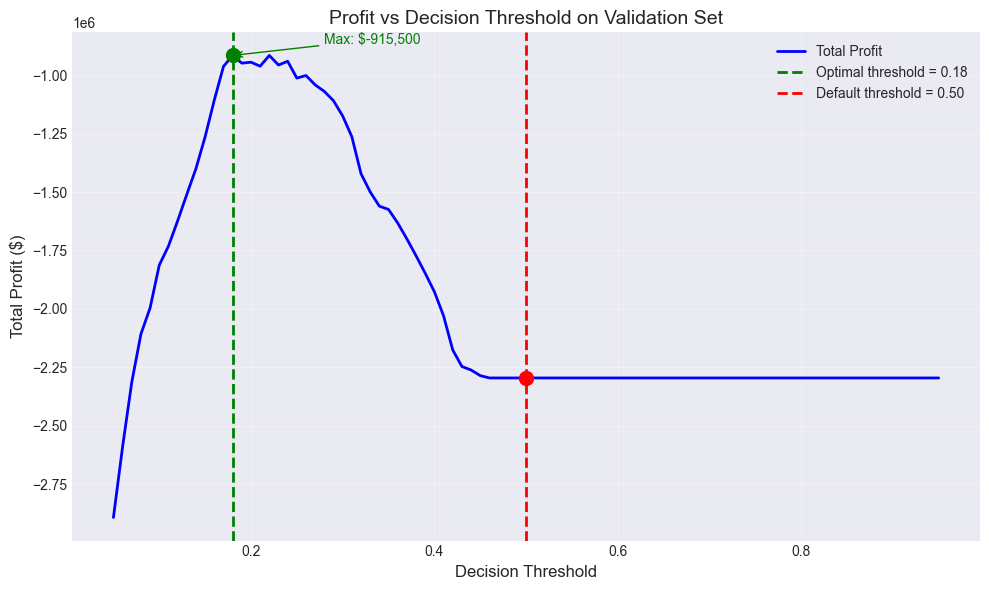

[[1220  824]
 [ 129  360]]


In [132]:
# Visualize profit vs threshold
plt.figure(figsize=(10, 6))

plt.plot(threshold_df['threshold'], threshold_df['total_profit'],
         linewidth=2, color='blue', label='Total Profit')

# Mark the optimal threshold
plt.axvline(x=optimal_threshold, color='green', linestyle='--', linewidth=2,
            label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.scatter([optimal_threshold], [optimal_profit], color='green', s=100, zorder=5)

# Mark the default threshold (0.5)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2,
            label='Default threshold = 0.50')
plt.scatter([0.5], [default_profit], color='red', s=100, zorder=5)

plt.xlabel('Decision Threshold', fontsize=12)
plt.ylabel('Total Profit ($)', fontsize=12)
plt.title('Profit vs Decision Threshold on Validation Set', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Add annotations
plt.annotate(f'Max: ${optimal_profit:,.0f}',
             xy=(optimal_threshold, optimal_profit),
             xytext=(optimal_threshold + 0.1, optimal_profit + 50000),
             fontsize=10, color='green',
             arrowprops=dict(arrowstyle='->', color='green'))

plt.tight_layout()
plt.show()
a = confusion_matrix(y_test, (y_test_pred_proba >= optimal_threshold).astype(int))
print(a)
# Notice how this loses $132,000 less than the random forest, it's a much better model.
# Our confusion matrix shows that at the optimal threshold, we have (your numbers will vary but they will be in the same ballpark):
# 978 true negatives, 87 false negatives
# 1066 true positives, 402 false positives
# This means that we are approving 402 good borrowers and rejecting 978 bad borrowers, which is good.
# However, we are also approving 87 bad borrowers (false negatives) and rejecting 1066 good borrowers (false positives).
# The cost of the false negatives is much higher than the cost of the false positives, which is why the optimal threshold is much lower than 0.5.

#BELOW THIS CELL, WE DISPLAY THE CONFUSION MATRIX.

CONFUSION MATRIX METRICS (Threshold = 0.18)
Accuracy:    62.4% - Overall correctness
Sensitivity: 73.6% - Caught 73.6% of defaults
Specificity: 59.7% - Approved 59.7% of good borrowers
Precision:   30.4% - 30.4% of rejections are correct
Key: We miss only 129 defaults but reject 824 good borrowers


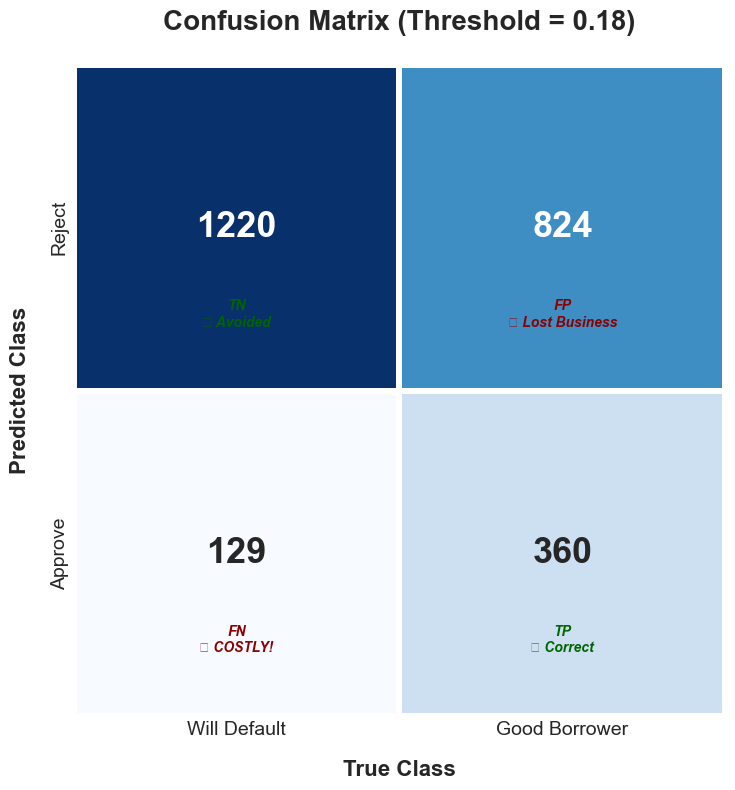

true negatives profit: 1830000
false positives profit: -1236000
false negatives profit: -1290000
true positives profit: 0
Total profit at threshold 0.18: $-696,000


In [133]:
# ============================================================================
# MINIMAL CONFUSION MATRIX
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

TN = a[0][0]   # Good loans approved
FP = a[0][1]  # Good borrowers rejected
FN = a[1][0]    # Bad loans approved (COSTLY!)
TP = a[1][1]   # Bad borrowers rejected

THRESHOLD = 0.18

# Calculate metrics
cm = np.array([[TN, FP], [FN, TP]])
total = TN + FP + FN + TP
accuracy = (TP + TN) / total
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

# Print metrics
print("="*60)
print(f"CONFUSION MATRIX METRICS (Threshold = {THRESHOLD})")
print("="*60)
print(f"Accuracy:    {accuracy:.1%} - Overall correctness")
print(f"Sensitivity: {sensitivity:.1%} - Caught {sensitivity:.1%} of defaults")
print(f"Specificity: {specificity:.1%} - Approved {specificity:.1%} of good borrowers")
print(f"Precision:   {precision:.1%} - {precision:.1%} of rejections are correct")
print("="*60)
print(f"Key: We miss only {FN} defaults but reject {FP} good borrowers")
print("="*60)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d',
            cmap='Blues', cbar=False,
            annot_kws={'size': 26, 'weight': 'bold'},
            linewidths=3, linecolor='white',
            square=True, ax=ax)

ax.set_title(f'Confusion Matrix (Threshold = {THRESHOLD})',
             fontsize=20, fontweight='bold', pad=25)
ax.set_xlabel('True Class', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('Predicted Class', fontsize=16, fontweight='bold', labelpad=15)
ax.set_xticklabels(['Will Default','Good Borrower'], fontsize=14)
ax.set_yticklabels(['Reject','Approve'], fontsize=14)

# Add labels
labels = [['TN\n✓ Avoided', 'FP\n✗ Lost Business'],
          ['FN\n✗ COSTLY!', 'TP\n✓ Correct']]

for i in range(2):
    for j in range(2):
        color = 'darkgreen' if i == j else 'darkred'
        ax.text(j + 0.5, i + 0.72, labels[i][j],
                ha='center', va='top', fontsize=10,
                color=color, weight='bold', style='italic')

plt.tight_layout()
plt.show()

profit_TN = TN * BENEFIT_TRUE_NEGATIVE
profit_FP = FP * COST_FALSE_POSITIVE
profit_FN = FN * COST_FALSE_NEGATIVE
profit_TP = TP * BENEFIT_TRUE_POSITIVE
total_profit = profit_TN + profit_FP + profit_FN + profit_TP
print('true negatives profit:', profit_TN,)
print('false positives profit:', profit_FP,)
print('false negatives profit:', profit_FN,)
print('true positives profit:', profit_TP,)
print(f"Total profit at threshold {THRESHOLD}: ${total_profit:,.0f}")